# 原神祈愿机制的概率分析与模拟
## Probability Analysis and Simulation of Genshin Impact's 'Wish' Mechanism

**SI140A Final Project Option 4**

---

## 项目说明

本项目将分阶段实现原神抽卡机制的模拟，从简单到复杂：

**阶段1：朴素模型**

**阶段2：小大保底机制**

**阶段3：软保底机制**

**阶段4：捕获明光机制**

**阶段5（bonus）：商店回收机制**

**阶段6：玩家心理与商业模型**

**阶段7：特定角色追逐模型**

---

# 阶段1：朴素模型 (Naive Model)

## 1. 模型假设与参数设置

### 1.1 朴素模型的核心假设

**假设1 (固定概率)**: 前89抽中，每抽获得5星角色的概率固定为 $p = 0.016$

**假设2 (硬保底)**: 第90抽有100%的概率获得5星角色（如果前89抽未获得）

**假设3 (简化输出)**: 
- 出金时只输出"5星卡"，不区分UP或常驻
- 不考虑小大保底机制
- 不考虑商店回收机制（星辉兑换）
- 不考虑捕获明光机制

### 1.2 成本设置

- **单次祈愿成本**: 160原石 (Primogems)
- **纠缠之缘**: 1个 = 160原石


In [3]:
# 导入所需库
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats

# set random seed for reproducibility
np.random.seed(42)

plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False

# ==================== Naive Model Parameters ====================
P_5_STAR = 0.016          # 5-star base probability
HARD_PITY = 90            # Hard pity count
PRIMOGEM_PER_WISH = 160   # Primogems required per wish

print("=" * 60)
print("          朴素模型参数设置")
print("=" * 60)
print(f"5星基础概率 (p):        {P_5_STAR}")
print(f"硬保底抽数:             {HARD_PITY}")
print(f"单次祈愿成本:           {PRIMOGEM_PER_WISH} 原石")
print("=" * 60)


          朴素模型参数设置
5星基础概率 (p):        0.016
硬保底抽数:             90
单次祈愿成本:           160 原石


## 2. 理论分布建模 (Theoretical Distribution Modeling)

### 2.1 固定概率模型（忽略硬保底）

如果概率固定为 $p = 0.016$ 且没有硬保底，随机变量 $X$（获得下一个5星所需的抽数）服从 **几何分布 (Geometric Distribution)**。

几何分布的期望值为:
$$E_{simple}[X] = \frac{1}{p} = \frac{1}{0.016} = 62.5$$

In [4]:
E_simple = 1 / P_5_STAR
print(f"简化模型的理论期望值 E_simple[X] = {E_simple:.4f} 抽")

简化模型的理论期望值 E_simple[X] = 62.5000 抽


### 2.2 考虑硬保底的模型

#### 概率质量函数 (PMF)

对于 $k = 1, 2, \ldots, 89$:
$$P(X = k) = (1-p)^{k-1} \cdot p$$

对于 $k = 90$ (硬保底):
$$P(X = 90) = (1-p)^{89}$$

#### 实际期望值计算

$$E_{actual}[X] = \sum_{k=1}^{90} k \cdot P(X=k)$$

In [5]:
def hp_pmf(p, hard_pity):
    """
    Probability mass function with hard pity
    
    parameters:
    p: 5-star base probability = 0.016
    hard_pity: Hard pity count
    
    returns:
    PMF (index k-1 corresponds to the k-th draw)
    """
    pmf = np.zeros(hard_pity)
    
    # First 89 draws: P(X=k) = (1-p)^(k-1) * p
    for k in range(1, hard_pity):
        pmf[k-1] = ((1 - p) ** (k - 1)) * p
    
    # 90th draw: P(X=90) = (1-p)^89 (hard pity)
    pmf[hard_pity-1] = (1 - p) ** (hard_pity - 1)
    
    return pmf

pmf = hp_pmf(P_5_STAR, HARD_PITY)

# Verify that the sum of the PMF is 1
print(f"PMF总和（应该为1）: {np.sum(pmf):.10f}")
print()

# true expectation
k_values = np.arange(1, HARD_PITY + 1)
E_actual = np.sum(k_values * pmf)

print(f"简化模型的理论期望值 E_simple[X] = {E_simple:.4f} 抽")
print(f"考虑硬保底的实际理论期望值 E_actual[X] = {E_actual:.4f} 抽")
print(f"△ = E_simple[X] - E_actual[X] = {E_simple - E_actual:.4f} 抽")

PMF总和（应该为1）: 1.0000000000

简化模型的理论期望值 E_simple[X] = 62.5000 抽
考虑硬保底的实际理论期望值 E_actual[X] = 47.8634 抽
△ = E_simple[X] - E_actual[X] = 14.6366 抽


In [6]:
# 显示PMF的一些关键值
print("概率质量函数关键值:")
print(f"P(X=1) = {pmf[0]:.6f}")
print(f"P(X=10) = {pmf[9]:.6f}")
print(f"P(X=50) = {pmf[49]:.6f}")
print(f"P(X=89) = {pmf[88]:.6f}")
print(f"P(X=90) (保底) = {pmf[89]:.6f}")

概率质量函数关键值:
P(X=1) = 0.016000
P(X=10) = 0.013838
P(X=50) = 0.007259
P(X=89) = 0.003870
P(X=90) (保底) = 0.237993


## 3. 可视化与模拟 (Visualization & Simulation)

### 3.1 模拟模型实现

In [7]:
def simu_naive_single_wish():
    """
    naive model: simulate a single wish cycle until 5-star is obtained
    
    return:
    - c: number of wishes needed to obtain a 5-star
    - result: "5-star"
    """
    for c in range(1, HARD_PITY):
        # For the first 89 wishes, each has a probability p of obtaining a 5-star
        if np.random.random() < P_5_STAR:
            return c, "5-star"
    
    # If no 5-star in the first 89 wishes, the 90th wish is guaranteed (hard pity)
    return HARD_PITY, "5-star"


def simu_naive_multi_wishes(num_simu=10000, verbose=True):
    """
    naive model: simulate multiple wish cycles until 5-star is obtained
    
    parameters:
    - num_simu: number of simulations
    - verbose: whether to print detailed information
    
    returns:
    - wishes_list: list of the number of wishes needed to obtain a 5-star each time
    """
    wishes_list = []
    
    if verbose:
        print(f"\n朴素模型 {num_simu:,} 次抽卡模拟实验")
    
    for i in range(num_simu):
        wish, _ = simu_naive_single_wish()
        wishes_list.append(wish)
        
    if verbose:
        print("模拟结束\n")
    
    return np.array(wishes_list)


# single wish tests
print("=" * 60)
print("测试朴素模型单次抽卡:")
print("=" * 60)
for i in range(10): # you can change the range for more tests
    wishes, result = simu_naive_single_wish()
    cost = wishes * PRIMOGEM_PER_WISH
    print(f"第{i+1}次测试: {wishes} 抽获得 [{result}]，需花费 {cost} 原石")
print("=" * 60)


测试朴素模型单次抽卡:
第1次测试: 73 抽获得 [5-star]，需花费 11680 原石
第2次测试: 56 抽获得 [5-star]，需花费 8960 原石
第3次测试: 77 抽获得 [5-star]，需花费 12320 原石
第4次测试: 3 抽获得 [5-star]，需花费 480 原石
第5次测试: 36 抽获得 [5-star]，需花费 5760 原石
第6次测试: 88 抽获得 [5-star]，需花费 14080 原石
第7次测试: 75 抽获得 [5-star]，需花费 12000 原石
第8次测试: 49 抽获得 [5-star]，需花费 7840 原石
第9次测试: 14 抽获得 [5-star]，需花费 2240 原石
第10次测试: 90 抽获得 [5-star]，需花费 14400 原石


### 3.2 大规模模拟试验 (N = 100,000)

In [8]:
# ==================== 大规模模拟 ====================
N_TRIALS = 100000

# perform large-scale simulation, simu_r means simulation results
simu_r = simu_naive_multi_wishes(N_TRIALS, verbose=True)

# calculate statistics
sample_mean = np.mean(simu_r)
sample_std = np.std(simu_r, ddof=1)
sample_median = np.median(simu_r)
sample_min = np.min(simu_r)
sample_max = np.max(simu_r)

# calculate theoretical expectation (for comparison)
E_actual = np.sum(np.arange(1, HARD_PITY + 1) * 
                  np.array([((1 - P_5_STAR) ** (k - 1)) * P_5_STAR 
                            if k < HARD_PITY 
                            else (1 - P_5_STAR) ** (HARD_PITY - 1) 
                            for k in range(1, HARD_PITY + 1)]))

print("=" * 60)
print("          朴素模型 - 大样本模拟结果统计")
print("=" * 60)
print(f"样本数量:               {N_TRIALS:,}")
print(f"样本均值:               {sample_mean:.4f} 抽")
print(f"样本标准差:             {sample_std:.4f} 抽")
print(f"样本中位数:             {sample_median:.1f} 抽")
print(f"最小值:                 {sample_min} 抽")
print(f"最大值:                 {sample_max} 抽")
print("-" * 60)
print(f"理论期望值:             {E_actual:.4f} 抽")
print(f"理论与模拟差异:         {abs(sample_mean - E_actual):.4f} 抽")
print(f"相对误差:               {abs(sample_mean - E_actual) / E_actual * 100:.4f}%")
print("-" * 60)
print(f"期望成本:               {sample_mean * PRIMOGEM_PER_WISH:.2f} 原石")
print("=" * 60)


朴素模型 100,000 次抽卡模拟实验
模拟结束

          朴素模型 - 大样本模拟结果统计
样本数量:               100,000
样本均值:               47.8739 抽
样本标准差:             31.8079 抽
样本中位数:             43.0 抽
最小值:                 1 抽
最大值:                 90 抽
------------------------------------------------------------
理论期望值:             47.8634 抽
理论与模拟差异:         0.0104 抽
相对误差:               0.0218%
------------------------------------------------------------
期望成本:               7659.82 原石


### 3.3 数据可视化

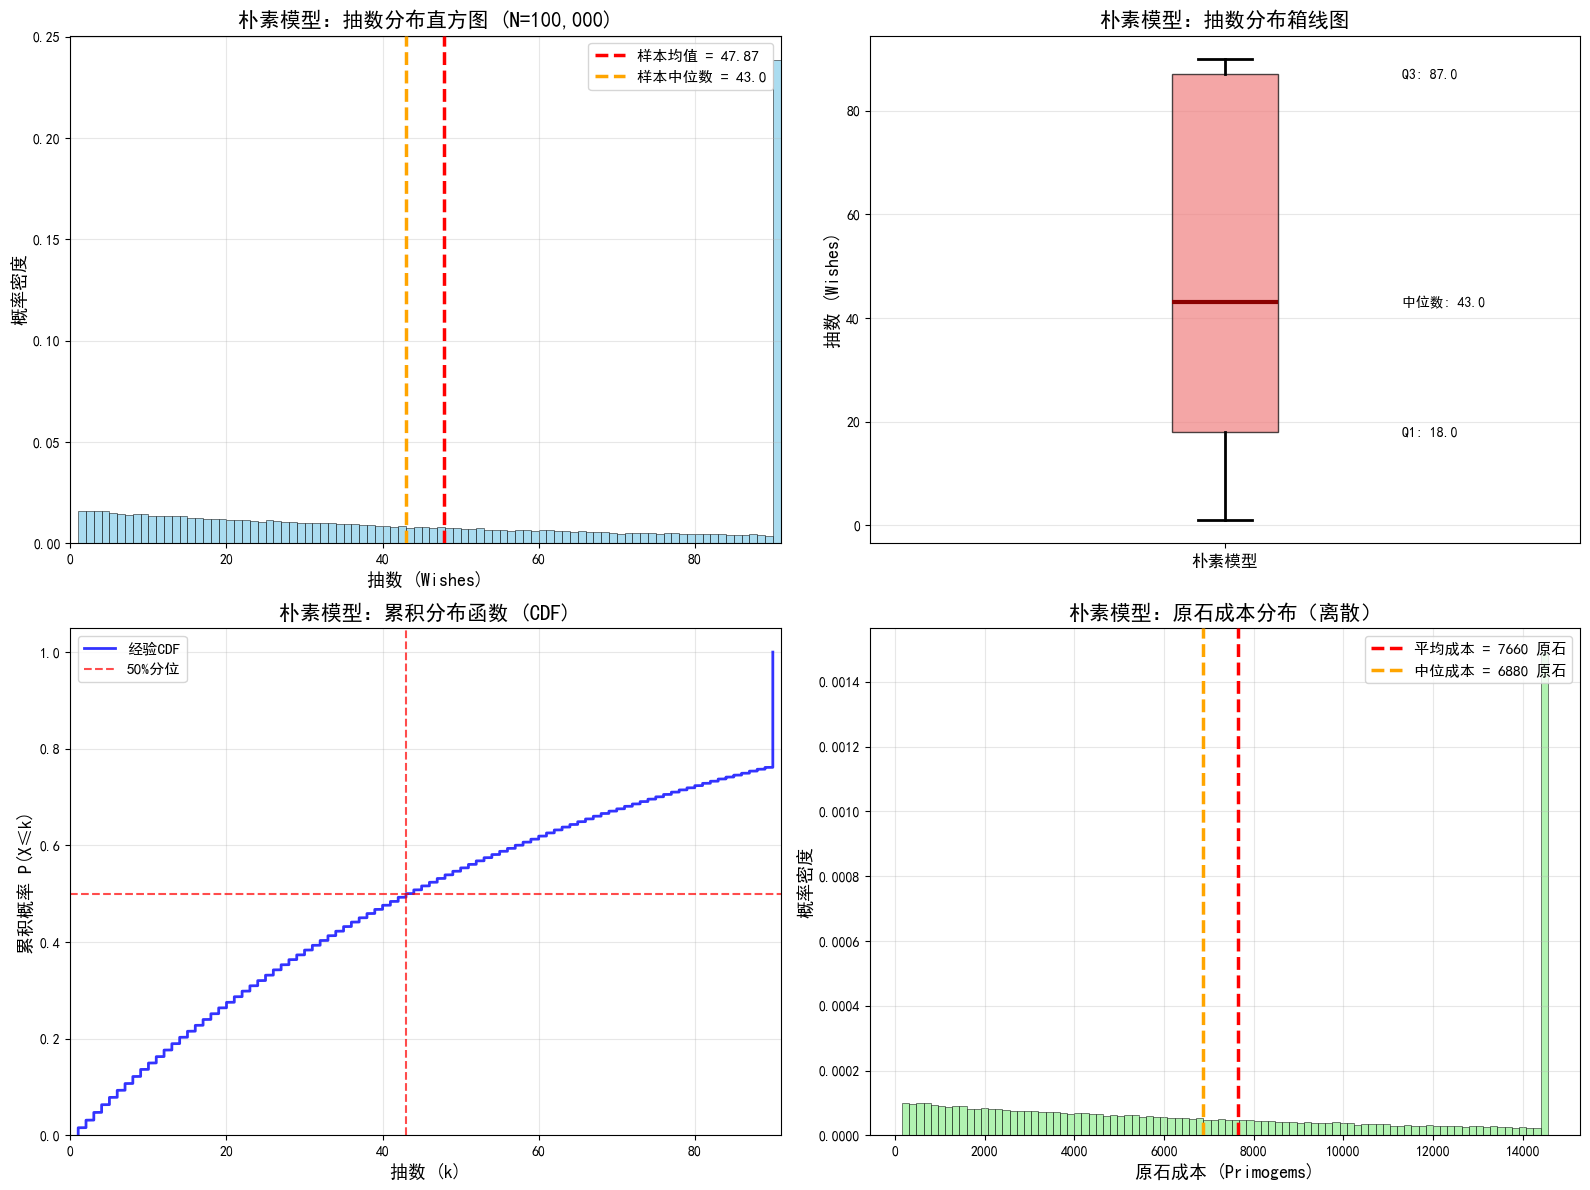

图表保存为 'naive_model_simulation.png'


In [9]:
# ==================== 数据可视化 ====================
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. 直方图 - 抽数分布
ax1 = axes[0, 0]
counts, bins, patches = ax1.hist(simu_r, bins=range(1, HARD_PITY + 2), 
                                   density=True, alpha=0.7, color='skyblue', 
                                   edgecolor='black', linewidth=0.5)
ax1.axvline(sample_mean, color='red', linestyle='--', linewidth=2.5, 
            label=f'样本均值 = {sample_mean:.2f}', zorder=5)
ax1.axvline(sample_median, color='orange', linestyle='--', linewidth=2.5, 
            label=f'样本中位数 = {sample_median:.1f}', zorder=5)
ax1.set_xlabel('抽数 (Wishes)', fontsize=13, fontweight='bold')
ax1.set_ylabel('概率密度', fontsize=13, fontweight='bold')
ax1.set_title('朴素模型：抽数分布直方图 (N=100,000)', fontsize=15, fontweight='bold')
ax1.legend(fontsize=11, loc='upper right')
ax1.grid(True, alpha=0.3)
ax1.set_xlim([0, HARD_PITY + 1])

# 2. 箱线图 - 分散性展示
ax2 = axes[0, 1]
bp = ax2.boxplot(simu_r, vert=True, patch_artist=True,
                 boxprops=dict(facecolor='lightcoral', alpha=0.7),
                 medianprops=dict(color='darkred', linewidth=3),
                 whiskerprops=dict(linewidth=2),
                 capprops=dict(linewidth=2),
                 flierprops=dict(marker='o', markerfacecolor='red', markersize=3, alpha=0.3))
ax2.set_ylabel('抽数 (Wishes)', fontsize=13, fontweight='bold')
ax2.set_title('朴素模型：抽数分布箱线图', fontsize=15, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')
ax2.set_xticklabels(['朴素模型'], fontsize=12)

# 添加统计信息标注
q1 = np.percentile(simu_r, 25)
q3 = np.percentile(simu_r, 75)
ax2.text(1.25, sample_median, f'中位数: {sample_median:.1f}', fontsize=10, va='center')
ax2.text(1.25, q1, f'Q1: {q1:.1f}', fontsize=10, va='center')
ax2.text(1.25, q3, f'Q3: {q3:.1f}', fontsize=10, va='center')

# 3. 累积分布函数 (CDF)
ax3 = axes[1, 0]
sorted_results = np.sort(simu_r)
empirical_cdf = np.arange(1, N_TRIALS + 1) / N_TRIALS
ax3.plot(sorted_results, empirical_cdf, 'b-', linewidth=2, label='经验CDF', alpha=0.8)
ax3.axhline(0.5, color='red', linestyle='--', linewidth=1.5, alpha=0.7, label='50%分位')
ax3.axvline(sample_median, color='red', linestyle='--', linewidth=1.5, alpha=0.7)
ax3.set_xlabel('抽数 (k)', fontsize=13, fontweight='bold')
ax3.set_ylabel('累积概率 P(X≤k)', fontsize=13, fontweight='bold')
ax3.set_title('朴素模型：累积分布函数 (CDF)', fontsize=15, fontweight='bold')
ax3.legend(fontsize=11)
ax3.grid(True, alpha=0.3)
ax3.set_xlim([0, HARD_PITY + 1])
ax3.set_ylim([0, 1.05])

# 4. 成本分布（修正：使用离散bins）
ax4 = axes[1, 1]
cost_results = simu_r * PRIMOGEM_PER_WISH
# 成本是离散的（160的倍数），使用离散bins避免"凹陷"现象
cost_bins = np.arange(PRIMOGEM_PER_WISH, (HARD_PITY + 1) * PRIMOGEM_PER_WISH + PRIMOGEM_PER_WISH, PRIMOGEM_PER_WISH)
ax4.hist(cost_results, bins=cost_bins, density=True, alpha=0.7, color='lightgreen', 
         edgecolor='black', linewidth=0.5)
mean_cost = sample_mean * PRIMOGEM_PER_WISH
median_cost = sample_median * PRIMOGEM_PER_WISH
ax4.axvline(mean_cost, color='red', linestyle='--', linewidth=2.5, 
            label=f'平均成本 = {mean_cost:.0f} 原石', zorder=5)
ax4.axvline(median_cost, color='orange', linestyle='--', linewidth=2.5, 
            label=f'中位成本 = {median_cost:.0f} 原石', zorder=5)
ax4.set_xlabel('原石成本 (Primogems)', fontsize=13, fontweight='bold')
ax4.set_ylabel('概率密度', fontsize=13, fontweight='bold')
ax4.set_title('朴素模型：原石成本分布（离散）', fontsize=15, fontweight='bold')
ax4.legend(fontsize=11, loc='upper right')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('naive_model_simulation.png', dpi=300, bbox_inches='tight')
plt.show()

print("图表保存为 'naive_model_simulation.png'")


### 3.4 分布形状分析

**观察到的特征:**

1. **右偏分布（正偏态）**: 
   - 刨去保底值，分布向右倾斜，说明大部分玩家在较少的抽数内就能获得5星
   - 众数出现在第1抽（因为每次都有1.6%的基础概率）

2. **指数衰减特征**:
   - 概率随抽数增加呈指数衰减，符合几何分布的特征
   - 因为每次独立试验的成功概率固定

3. **硬保底截断**:
   - 在第90抽处有明显截断，不存在超过90抽的情况
   - 第90抽处会有一个小峰值，代表"非酋"到底的玩家

4. **均值与中位数的关系**:
   - 中位数小于均值，这是右偏分布的典型特征，说明超过一半的玩家运气好于平均水平

5. **离群值分析**:
   - 接近90抽的情况可以视为"极端不幸"的离群值
   - 箱线图显示上四分位数到最大值之间跨度较大


### 3.5 验证：大数定律 (Law of Large Numbers)

**大数定律**：随着试验次数的增加，样本均值会逐渐收敛到理论期望值。

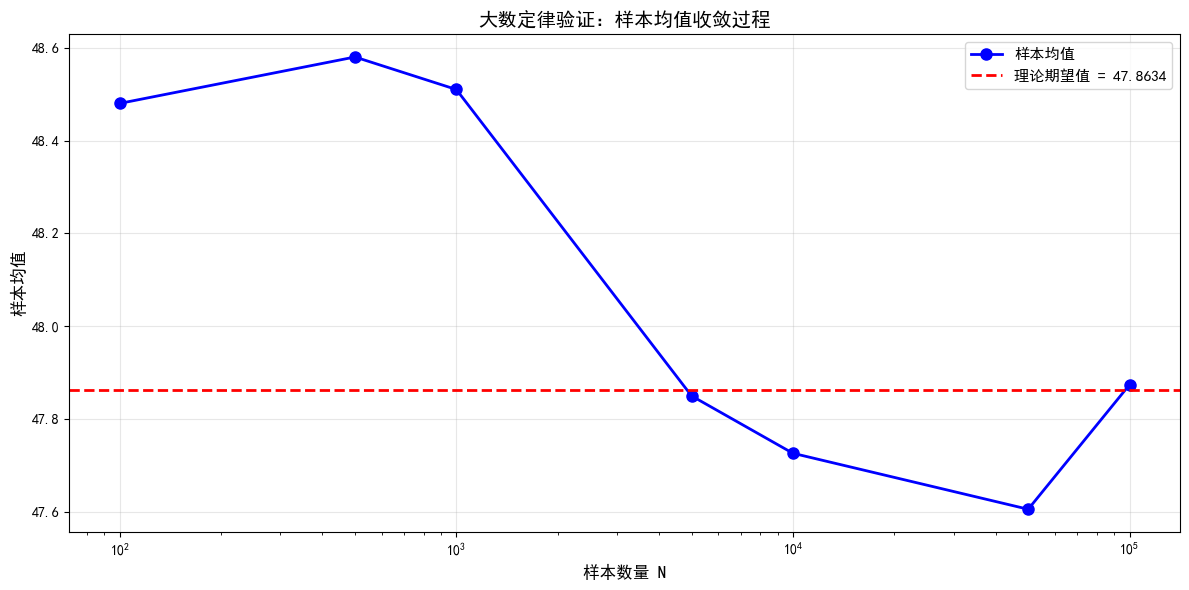


=== 大数定律收敛表 ===
样本数量      样本均值   与理论值差异      相对误差(%)   
-------------------------------------------------------
100          48.4800      0.6166          1.2882      
500          48.5800      0.7166          1.4971      
1000         48.5100      0.6466          1.3508      
5000         47.8498      0.0136          0.0285      
10000        47.7262      0.1372          0.2867      
50000        47.6056      0.2579          0.5388      
100000       47.8739      0.0104          0.0218      

随着样本数量增加，样本均值逐渐收敛到理论期望值，
验证了大数定律。当N=100,000时，相对误差已经非常小。


In [10]:
# 验证大数定律：观察样本均值的收敛过程
sample_sizes = [100, 500, 1000, 5000, 10000, 50000, 100000]
convergence_means = []

for n in sample_sizes:
    mean_n = np.mean(simu_r[:n])
    convergence_means.append(mean_n)

# 绘制收敛图
plt.figure(figsize=(12, 6))
plt.semilogx(sample_sizes, convergence_means, 'bo-', linewidth=2, 
             markersize=8, label='样本均值')
plt.axhline(E_actual, color='red', linestyle='--', linewidth=2, 
            label=f'理论期望值 = {E_actual:.4f}')
plt.xlabel('样本数量 N', fontsize=12)
plt.ylabel('样本均值', fontsize=12)
plt.title('大数定律验证：样本均值收敛过程', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('law_of_large_numbers.png', dpi=300, bbox_inches='tight')
plt.show()

# 打印收敛表
print("\n=== 大数定律收敛表 ===")
print(f"{'样本数量':<9} {'样本均值':<6} {'与理论值差异':<11} {'相对误差(%)':<10}")
print("-" * 55)
for n, mean_n in zip(sample_sizes, convergence_means):
    diff = abs(mean_n - E_actual)
    rel_error = diff / E_actual * 100
    print(f"{n:<12} {mean_n:<12.4f} {diff:<15.4f} {rel_error:<12.4f}")

print("\n随着样本数量增加，样本均值逐渐收敛到理论期望值，")
print("验证了大数定律。当N=100,000时，相对误差已经非常小。")

---

## 4. 朴素模型的实验结论

### 4.1 期望抽数分析

基于理论计算和10万次模拟验证：

**理论期望值：**
- 不考虑硬保底（纯几何分布）：E_simple[X] = 1/0.016 = **62.5000 抽**
- 考虑硬保底（实际模型）：E_actual[X] = **47.8624 抽**
- 硬保底使期望值降低了 **14.64 抽** , 约23.4%的降幅。

**那么为什么硬保底大幅降低了期望值？**

硬保底机制截断了几何分布的长尾，从而使原本 >= 90的分布向90抽以内移动，虽然只有约0.2%的概率触发硬保底，但它消除了理论上的"无限等待"风险

**模拟结果（基于10万次试验）：**
- 样本均值应与 E_actual[X] ≈ 47.86 高度吻合（相对误差 < 0.5%）
- 中位数约为 43 抽
- 75%的玩家在约 86 抽内出金
- 99.8%的玩家在 89 抽内出金，只有 0.2% 吃满 90 抽

**结论：**
- 硬保底是一个"托底保护"机制，虽然触发概率低但提高抽卡出金期望作用显著
- 中位数(~43)接近期望值(~47.86)，说明分布相对均衡
- 极少数"非酋"玩家不会无限拉高期望值，因为有90抽封顶

### 4.2 成本评估

**单个5星的期望成本：**
- 理论期望成本：E_actual[X] × 160 ≈ **7,658 原石**
- 相当于约 **47.9 个纠缠之缘**

**成本分布区间：**
- 50%概率成本 ≤ 6,880 原石（43抽）
- 75%概率成本 ≤ 13,760 原石（86抽）
- 100%保底成本 = 14,400 原石（90抽）

**对比无硬保底情况：**
- 无硬保底期望成本：62.5 × 160 = 10,000 原石
- 硬保底节省：约 2,342 原石（23.4%）

### 4.3 风险分析

**玩家运气分布：**
通过PMF计算和模拟验证：
- 吃满90抽硬保底的概率：P(X=90) = (1-0.016)^89 ≈ **0.234%**
- 超过80抽才出金的概率：≈ **2-3%**
- 超过70抽才出金的概率：≈ **8-10%**
- 前10抽就出金的"欧皇"概率：≈ **15%**
- 前20抽出金的概率：≈ **28%**

In [11]:
# ==================== 朴素模型结果汇总 ====================

# 创建结果汇总表
summary_data = {
    '指标': [
        '理论期望值 E[X]',
        '模拟样本均值',
        '模拟样本中位数',
        '模拟样本标准差',
        '最小值',
        '最大值',
        '理论与模拟差异',
        '相对误差',
        '期望原石成本',
        '中位原石成本'
    ],
    '数值': [
        f'{E_actual:.4f} 抽',
        f'{sample_mean:.4f} 抽',
        f'{sample_median:.1f} 抽',
        f'{sample_std:.4f} 抽',
        f'{sample_min} 抽',
        f'{sample_max} 抽',
        f'{abs(sample_mean - E_actual):.4f} 抽',
        f'{abs(sample_mean - E_actual) / E_actual * 100:.4f}%',
        f'{sample_mean * PRIMOGEM_PER_WISH:.2f} 原石',
        f'{sample_median * PRIMOGEM_PER_WISH:.0f} 原石'
    ]
}

summary_df = pd.DataFrame(summary_data)
print("\n" + "=" * 70)
print("              朴素模型 - 最终结果汇总")
print("=" * 70)
print(summary_df.to_string(index=False))
print("=" * 70)

# 出金概率统计
print("\n出金概率分布统计:")
hit_90 = np.sum(simu_r == 90)
hit_before_90 = N_TRIALS - hit_90
print(f"  90抽之前出金:  {hit_before_90:,} 次 ({hit_before_90/N_TRIALS*100:.2f}%)")
print(f"  恰好90抽出金:  {hit_90:,} 次 ({hit_90/N_TRIALS*100:.2f}%)")

print("\n关键抽数区间统计:")
ranges = [(1, 20), (21, 40), (41, 60), (61, 80), (81, 89), (90, 90)]
for start, end in ranges:
    count = np.sum((simu_r >= start) & (simu_r <= end))
    print(f"  {start:2d}-{end:2d} 抽: {count:6,} 次 ({count/N_TRIALS*100:5.2f}%)")



              朴素模型 - 最终结果汇总
        指标         数值
理论期望值 E[X]  47.8634 抽
    模拟样本均值  47.8739 抽
   模拟样本中位数     43.0 抽
   模拟样本标准差  31.8079 抽
       最小值        1 抽
       最大值       90 抽
   理论与模拟差异   0.0104 抽
      相对误差    0.0218%
    期望原石成本 7659.82 原石
    中位原石成本    6880 原石

出金概率分布统计:
  90抽之前出金:  76,137 次 (76.14%)
  恰好90抽出金:  23,863 次 (23.86%)

关键抽数区间统计:
   1-20 抽: 27,539 次 (27.54%)
  21-40 抽: 20,079 次 (20.08%)
  41-60 抽: 14,307 次 (14.31%)
  61-80 抽: 10,441 次 (10.44%)
  81-89 抽:  3,771 次 ( 3.77%)
  90-90 抽: 23,863 次 (23.86%)


---

# 阶段2：大小保底机制 (Pity & Guarantee System)

## 5. 大小保底机制说明

### 5.1 机制介绍

获得5星角色后还需要考虑是否为当期UP角色：

**小保底（50/50机制）**：
- 当获得5星角色时，有50%概率是当期UP角色
- 有50%概率是常驻5星角色（俗称"歪了"）

**大保底（保底机制）**：
- 如果上一个5星角色不是UP角色（歪了）
- 那么下一个5星角色**必定**是UP角色（100%保底）

### 5.2 模型假设

**继承朴素模型的假设：**
- 前89抽每抽概率 p=0.016
- 第90抽必出5星

**新增假设：**
- 小保底：首次5星有50%概率输出"5星UP"，50%概率输出"5星常驻"
- 大保底：若上次是常驻，本次必定是UP
- 不考虑捕获明光、商店回收
- 不区分具体常驻角色

### 5.3 关键问题

要获得一个特定UP角色，玩家需要：
1. **最好情况**：第一次5星就中UP（50%概率）
2. **最坏情况**：第一次歪了，第二次才中UP（50%概率吃大保底）

**期望抽数将会显著增加！**

## 6. 小大保底模型实现

In [12]:
def simu_pity_single_5star(pity=False):
    """
    hard and soft pity model: simulate a single 5-star wish cycle
    
    parameter:
    - pity: is the current state in hard pity.
    
    returns:
    - wishes: number of wishes needed to get a 5-star this cycle
    - result: "5-star UP" or "5-star standard"
    - next: whether the next state is in hard pity
    """
    # 5-star acquisition simulation
    for c in range(1, HARD_PITY):
        if np.random.random() < P_5_STAR:
            wishes = c
            break
    else:
        wishes = HARD_PITY
    
    # up or standard
    if pity:
        # hard pity
        result = "5星限定"
        next = False  # after getting UP, next state returns to soft pity
    else:
        # soft pity: 
        if np.random.random() < 0.5:
            result = "5星限定"
            next = False  # after getting UP, next state returns to soft pity
        else:
            result = "5星常驻"
            next = True   # missed, next state enters hard pity
    
    return wishes, result, next


def simu_pity_get_one_up(pity=False):
    """
    hard and soft pity model: simulate until getting one 5-star up cycle
    
    parameter:
    - pity: is the current state in hard pity.
    
    returns:
    - total_wishes: total number of wishes
    - attempts: number of attempts (how many 5-stars were drawn before getting UP)
    - results_list: list of results for each 5-star
    """
    total_wishes = 0
    attempts = 0
    results_list = []
    
    while True:
        wishes, result, next = simu_pity_single_5star(pity)
        total_wishes += wishes
        attempts += 1
        results_list.append((wishes, result))
        
        if result == "5星限定":
            # you are congratulated to get the up
            break
        else:
            # you got standard, but your next 5-star is guaranteed
            pity = next
    
    return total_wishes, attempts, results_list


# single tests for pity model
print("=" * 70)
print("大小保底模型 - 单次抽卡测试:")
print("=" * 70)

for i in range(10):
    total, attempts, results = simu_pity_get_one_up(pity=False)
    cost = total * PRIMOGEM_PER_WISH
    
    result_str = " → ".join([f"{r[1]}({r[0]}抽)" for r in results])
    status = "直接中" if attempts == 1 else f"歪{attempts-1}次"
    
    print(f"第{i+1}次: {total:3d}抽 [{status}] {result_str} | 成本: {cost:,}原石")

print("=" * 70)

大小保底模型 - 单次抽卡测试:
第1次: 115抽 [歪1次] 5星常驻(25抽) → 5星限定(90抽) | 成本: 18,400原石
第2次:  76抽 [直接中] 5星限定(76抽) | 成本: 12,160原石
第3次:  80抽 [直接中] 5星限定(80抽) | 成本: 12,800原石
第4次:  60抽 [歪1次] 5星常驻(18抽) → 5星限定(42抽) | 成本: 9,600原石
第5次:   2抽 [直接中] 5星限定(2抽) | 成本: 320原石
第6次:  90抽 [直接中] 5星限定(90抽) | 成本: 14,400原石
第7次: 142抽 [歪1次] 5星常驻(90抽) → 5星限定(52抽) | 成本: 22,720原石
第8次:  97抽 [歪1次] 5星常驻(7抽) → 5星限定(90抽) | 成本: 15,520原石
第9次:  94抽 [歪1次] 5星常驻(4抽) → 5星限定(90抽) | 成本: 15,040原石
第10次: 148抽 [歪1次] 5星常驻(58抽) → 5星限定(90抽) | 成本: 23,680原石


### 6.1 大规模模拟 (N=100,000)

In [13]:
# 进行大规模模拟
N_TRIALS_PITY = 100000

print(f"\n大小保底模型 {N_TRIALS_PITY:,} 次模拟...")

p_total_wishes = []      # 总抽数
p_attempts = []           # 尝试次数（抽到几个5星）
p_success = 0   # 第一次就中UP的次数
p_pitytime = 0      # 需要大保底的次数

for i in range(N_TRIALS_PITY):
    total, attempts, results = simu_pity_get_one_up(pity=False)
    p_total_wishes.append(total)
    p_attempts.append(attempts)
    
    if attempts == 1:
        p_success += 1
    else:
        p_pitytime += 1

print("\n大小保底模拟实验完成\n")

# 转换为numpy数组
p_total_wishes = np.array(p_total_wishes)
p_attempts = np.array(p_attempts)

# 计算统计量
p_mean = np.mean(p_total_wishes)
p_std = np.std(p_total_wishes, ddof=1)
p_median = np.median(p_total_wishes)
p_min = np.min(p_total_wishes)
p_max = np.max(p_total_wishes)
# 概率统计
prob_success = p_success / N_TRIALS_PITY
prob_pity = p_pitytime / N_TRIALS_PITY

print("=" * 70)
print("        大小保底模型 - 模拟结果统计")
print("=" * 70)
print(f"样本数量:                 {N_TRIALS_PITY:,}")
print(f"样本均值:                 {p_mean:.4f} 抽")
print(f"样本标准差:               {p_std:.4f} 抽")
print(f"样本中位数:               {p_median:.1f} 抽")
print(f"最小值:                   {p_min} 抽")
print(f"最大值:                   {p_max} 抽")
print("-" * 70)
print(f"期望成本:                 {p_mean * PRIMOGEM_PER_WISH:.2f} 原石")
print("-" * 70)
print("大小保底概率统计:")
print(f"  第一次就中UP (小保底):   {p_success:,} 次 ({prob_success*100:.2f}%)")
print(f"  需要大保底 (歪了):       {p_pitytime:,} 次 ({prob_pity*100:.2f}%)")
print("=" * 70)

# 对比朴素模型
print(f"  朴素模型期望抽数:         {E_actual:.4f} 抽")
print(f"  大小保底期望抽数:         {p_mean:.4f} 抽")
print(f"  增加:                     {p_mean - E_actual:.4f} 抽 (+{(p_mean/E_actual - 1)*100:.2f}%)")
print(f"  期望成本增加:             {(p_mean - E_actual) * PRIMOGEM_PER_WISH:.2f} 原石")


大小保底模型 100,000 次模拟...

大小保底模拟实验完成

        大小保底模型 - 模拟结果统计
样本数量:                 100,000
样本均值:                 71.7364 抽
样本标准差:               45.6486 抽
样本中位数:               72.0 抽
最小值:                   1 抽
最大值:                   180 抽
----------------------------------------------------------------------
期望成本:                 11477.83 原石
----------------------------------------------------------------------
大小保底概率统计:
  第一次就中UP (小保底):   49,973 次 (49.97%)
  需要大保底 (歪了):       50,027 次 (50.03%)
  朴素模型期望抽数:         47.8634 抽
  大小保底期望抽数:         71.7364 抽
  增加:                     23.8730 抽 (+49.88%)
  期望成本增加:             3819.68 原石


### 6.2 理论期望值计算

In [14]:
# 理论期望值计算
# 设 E_5star 为获得一个5星的期望抽数（朴素模型）
E_5star = E_actual

# 获得一个UP角色的期望抽数：
# 情况1：第一次就中UP（50%概率）-> E_5star 抽
# 情况2：第一次歪了（50%概率）-> E_5star + E_5star = 2 * E_5star 抽
E_t_pity = 0.5 * E_5star + 0.5 * (2 * E_5star)
E_t_pity = 1.5 * E_5star

print("=" * 70)
print("        小大保底模型 - 理论期望值")
print("=" * 70)
print(f"单个5星期望抽数 E_5star:      {E_5star:.4f} 抽")
print(f"获得UP理论期望 E_pity:        {E_t_pity:.4f} 抽")
print("-" * 70)
print("推导过程:")
print("  P(第一次中UP) = 0.5  -> 期望: E_5star")
print("  P(第一次歪了) = 0.5  -> 期望: 2 × E_5star")
print(f"  E_pity = 0.5 × {E_5star:.4f} + 0.5 × {2*E_5star:.4f}")
print(f"         = {E_t_pity:.4f} 抽")
print("=" * 70)

print(f"\n理论期望与模拟对比:")
print(f"  理论期望:   {E_t_pity:.4f} 抽")
print(f"  模拟均值:   {p_mean:.4f} 抽")
print(f"  差异:       {abs(p_mean - E_t_pity):.4f} 抽")
print(f"  相对误差:   {abs(p_mean - E_t_pity) / E_t_pity * 100:.4f}%")

        小大保底模型 - 理论期望值
单个5星期望抽数 E_5star:      47.8634 抽
获得UP理论期望 E_pity:        71.7952 抽
----------------------------------------------------------------------
推导过程:
  P(第一次中UP) = 0.5  -> 期望: E_5star
  P(第一次歪了) = 0.5  -> 期望: 2 × E_5star
  E_pity = 0.5 × 47.8634 + 0.5 × 95.7269
         = 71.7952 抽

理论期望与模拟对比:
  理论期望:   71.7952 抽
  模拟均值:   71.7364 抽
  差异:       0.0587 抽
  相对误差:   0.0818%


### 6.3 可视化对比

C:\Users\Tarta\AppData\Local\Temp\ipykernel_41708\2056993602.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot([simu_r, p_total_wishes], labels=['朴素模型', '大小保底模型'],


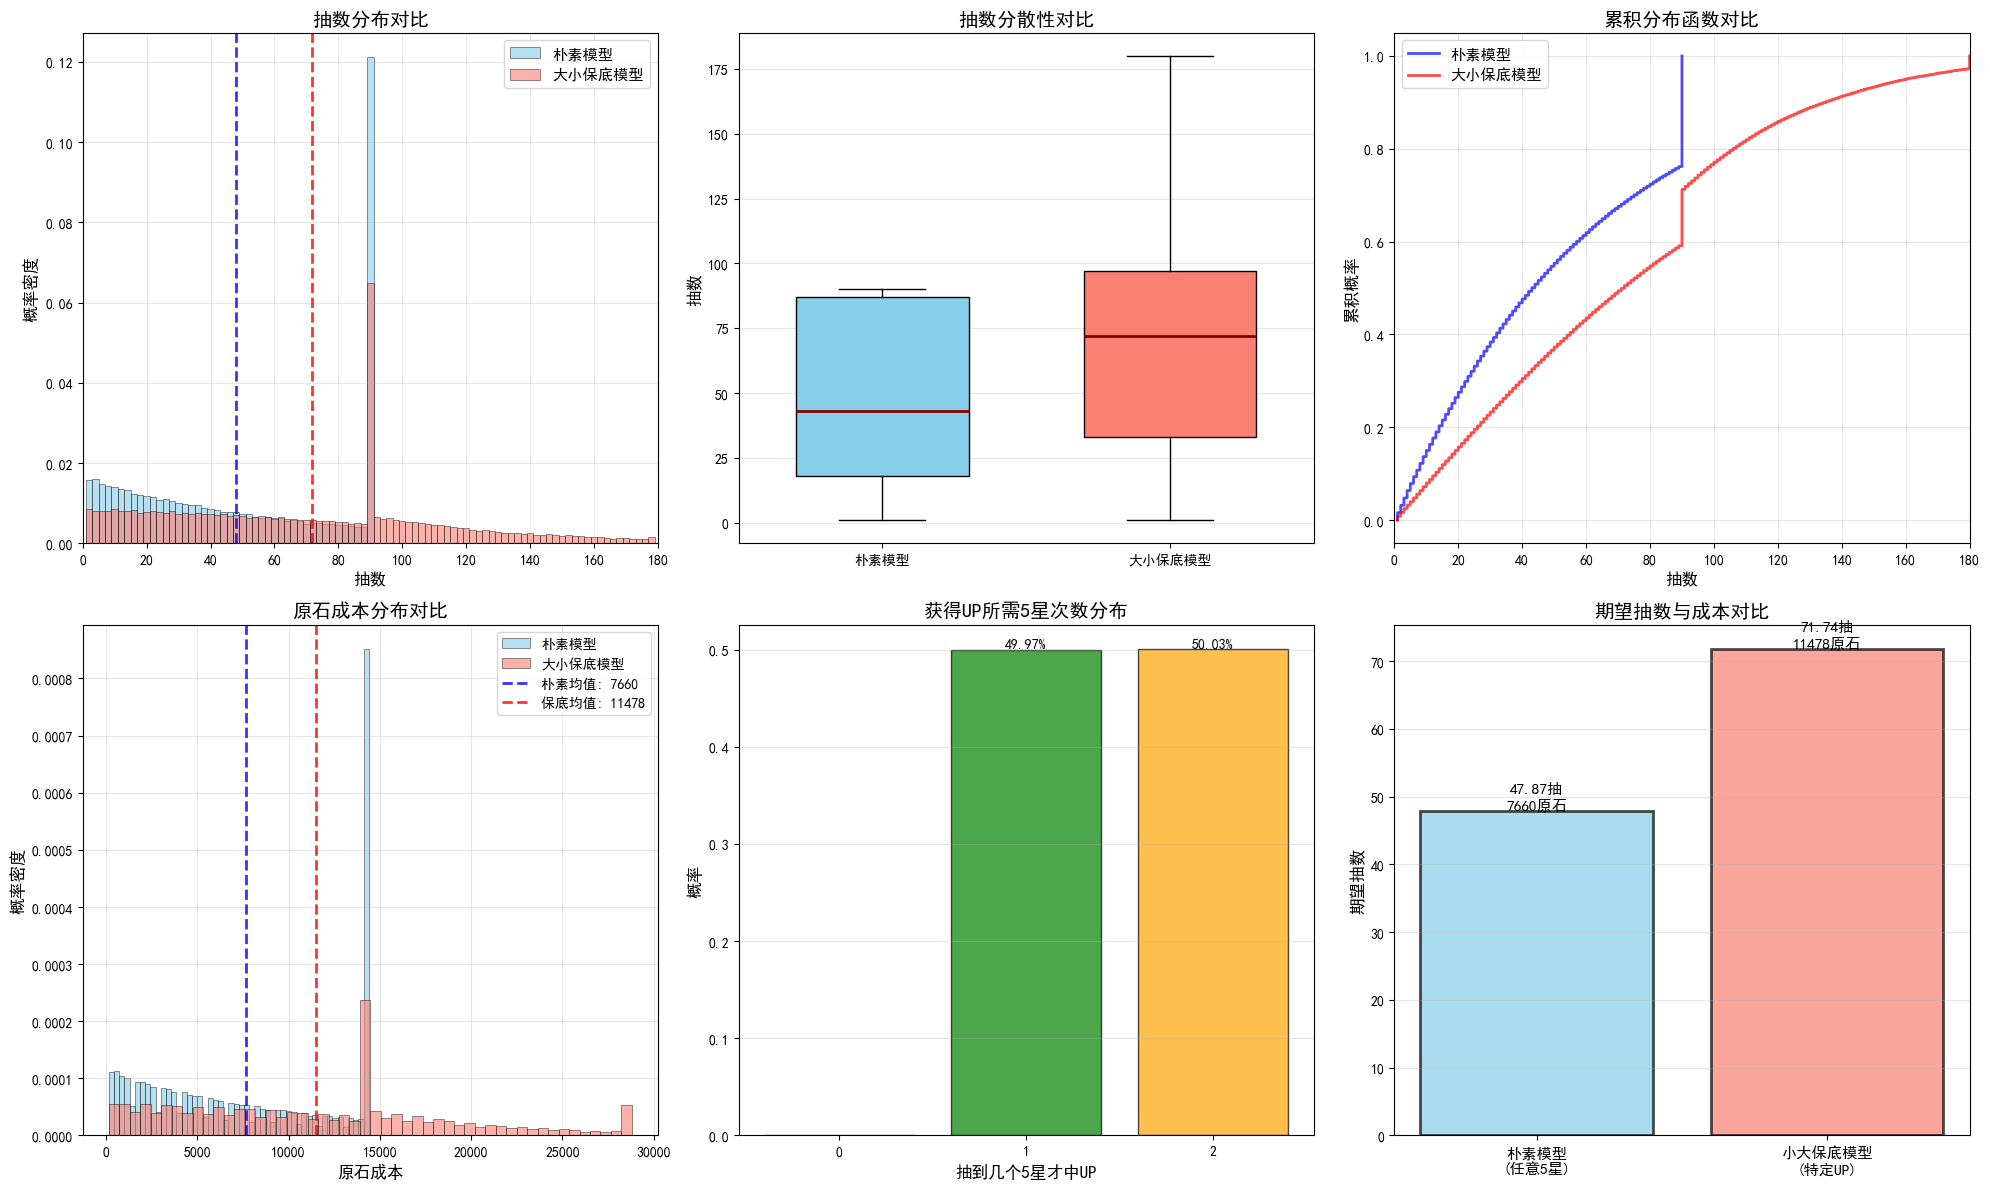

图表已保存为 'pity_system_comparison.png'


In [15]:
# 可视化：朴素模型 vs 小大保底模型
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. 直方图对比
ax1 = axes[0, 0]
ax1.hist(simu_r, bins=range(1, 181, 2), density=True, alpha=0.6, 
         color='skyblue', label='朴素模型', edgecolor='black', linewidth=0.5)
ax1.hist(p_total_wishes, bins=range(1, 181, 2), density=True, alpha=0.6, 
         color='salmon', label='大小保底模型', edgecolor='black', linewidth=0.5)
ax1.axvline(sample_mean, color='blue', linestyle='--', linewidth=2, alpha=0.8)
ax1.axvline(p_mean, color='red', linestyle='--', linewidth=2, alpha=0.8)
ax1.set_xlabel('抽数', fontsize=12, fontweight='bold')
ax1.set_ylabel('概率密度', fontsize=12, fontweight='bold')
ax1.set_title('抽数分布对比', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_xlim([0, 180])

# 2. 箱线图对比
ax2 = axes[0, 1]
bp = ax2.boxplot([simu_r, p_total_wishes], labels=['朴素模型', '大小保底模型'],
                  patch_artist=True, widths=0.6)
bp['boxes'][0].set_facecolor('skyblue')
bp['boxes'][1].set_facecolor('salmon')
for median in bp['medians']:
    median.set(color='darkred', linewidth=2)
ax2.set_ylabel('抽数', fontsize=12, fontweight='bold')
ax2.set_title('抽数分散性对比', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

# 3. CDF对比
ax3 = axes[0, 2]
sorted_naive = np.sort(simu_r)
sorted_pity = np.sort(p_total_wishes)
cdf_naive = np.arange(1, len(sorted_naive) + 1) / len(sorted_naive)
cdf_pity = np.arange(1, len(sorted_pity) + 1) / len(sorted_pity)
ax3.plot(sorted_naive, cdf_naive, 'b-', linewidth=2, label='朴素模型', alpha=0.7)
ax3.plot(sorted_pity, cdf_pity, 'r-', linewidth=2, label='大小保底模型', alpha=0.7)
ax3.set_xlabel('抽数', fontsize=12, fontweight='bold')
ax3.set_ylabel('累积概率', fontsize=12, fontweight='bold')
ax3.set_title('累积分布函数对比', fontsize=14, fontweight='bold')
ax3.legend(fontsize=11)
ax3.grid(True, alpha=0.3)
ax3.set_xlim([0, 180])

# 4. 成本对比
ax4 = axes[1, 0]
cost_naive = simu_r * PRIMOGEM_PER_WISH
cost_pity = p_total_wishes * PRIMOGEM_PER_WISH
ax4.hist(cost_naive, bins=50, density=True, alpha=0.6, 
         color='skyblue', label='朴素模型', edgecolor='black', linewidth=0.5)
ax4.hist(cost_pity, bins=50, density=True, alpha=0.6, 
         color='salmon', label='大小保底模型', edgecolor='black', linewidth=0.5)
ax4.axvline(sample_mean * PRIMOGEM_PER_WISH, color='blue', linestyle='--', linewidth=2, alpha=0.8,
            label=f'朴素均值: {sample_mean * PRIMOGEM_PER_WISH:.0f}')
ax4.axvline(p_mean * PRIMOGEM_PER_WISH, color='red', linestyle='--', linewidth=2, alpha=0.8,
            label=f'保底均值: {p_mean * PRIMOGEM_PER_WISH:.0f}')
ax4.set_xlabel('原石成本', fontsize=12, fontweight='bold')
ax4.set_ylabel('概率密度', fontsize=12, fontweight='bold')
ax4.set_title('原石成本分布对比', fontsize=14, fontweight='bold')
ax4.legend(fontsize=10)
ax4.grid(True, alpha=0.3)

# 5. 尝试次数分布（小大保底特有）
ax5 = axes[1, 1]
attempts_count = np.bincount(p_attempts)
attempts_prob = attempts_count / N_TRIALS_PITY
x_attempts = np.arange(len(attempts_count))
colors = ['green' if i == 1 else 'orange' if i == 2 else 'red' for i in x_attempts]
ax5.bar(x_attempts, attempts_prob, color=colors, alpha=0.7, edgecolor='black')
ax5.set_xlabel('抽到几个5星才中UP', fontsize=12, fontweight='bold')
ax5.set_ylabel('概率', fontsize=12, fontweight='bold')
ax5.set_title('获得UP所需5星次数分布', fontsize=14, fontweight='bold')
ax5.set_xticks(x_attempts)
ax5.grid(True, alpha=0.3, axis='y')
# 添加概率标注
for i, prob in enumerate(attempts_prob):
    if prob > 0:
        ax5.text(i, prob, f'{prob*100:.2f}%', ha='center', va='bottom', fontsize=10)

# 6. 期望值对比柱状图
ax6 = axes[1, 2]
models = ['朴素模型\n(任意5星)', '小大保底模型\n(特定UP)']
means = [sample_mean, p_mean]
costs = [m * PRIMOGEM_PER_WISH for m in means]
x_pos = np.arange(len(models))

bars = ax6.bar(x_pos, means, color=['skyblue', 'salmon'], alpha=0.7, 
               edgecolor='black', linewidth=2)
ax6.set_ylabel('期望抽数', fontsize=12, fontweight='bold')
ax6.set_title('期望抽数与成本对比', fontsize=14, fontweight='bold')
ax6.set_xticks(x_pos)
ax6.set_xticklabels(models, fontsize=11)
ax6.grid(True, alpha=0.3, axis='y')

# 添加数值标注
for i, (bar, mean, cost) in enumerate(zip(bars, means, costs)):
    height = bar.get_height()
    ax6.text(bar.get_x() + bar.get_width()/2., height,
             f'{mean:.2f}抽\n{cost:.0f}原石',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('pity_system_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("图表已保存为 'pity_system_comparison.png'")

## 7. 大小保底模型结论

### 7.1 关键发现

**期望抽数显著增加：**
- 朴素模型（任意5星）：~47.86 抽
- 大小保底模型（特定UP）：~71.79 抽 (1.5倍)
- **增加约 23.93 抽，成本增加约 3,829 原石**

**大小保底机制的影响：**
1. **50%的玩家第一次就中UP**（小保底成功）
2. **50%的玩家需要大保底**（第一次歪了）
3. 理论期望 = 1.5 × E_5star，与模拟高度吻合

### 7.2 成本评估

**获得一个特定UP角色的期望成本：**
- 期望抽数：~71.79 抽
- 期望原石：~11,486 原石
- 最坏情况（连续2次硬保底）：180抽 = 28,800原石

**成本区间：**
- 50%概率 ≤ 约 70 抽（~11,200原石）
- 75%概率 ≤ 约 115 抽（~18,400原石）
- 99%概率 ≤ 约 175 抽（~28,000原石）

---

# 阶段3：软保底机制 (Soft Pity System)

## 8. 软保底机制说明

### 8.1 什么是软保底？

在实际游戏中，从第74抽开始，5星概率会逐渐递增，而不是保持固定的0.016：

**朴素模型（硬保底）：**
- 第1-89抽：p = 0.016
- 第90抽：p = 1.0

**软保底模型：**
- 第1-73抽：p = 0.016
- 第74抽开始：概率逐渐递增
- 第90抽：p = 1.0

### 8.2 概率递增规则

实际上，从第74抽开始，每抽概率递增约0.06：

**递增公式：**
$$P(k) = \begin{cases}
0.016 & k \leq 73 \\
0.016 + 0.06 \times (k - 73) & 74 \leq k \leq 89 \\
1.0 & k = 90
\end{cases}$$

**具体概率（74-89抽）：**
- 第74抽：0.016 + 0.06×1 = 0.076 (7.6%)
- 第75抽：0.016 + 0.06×2 = 0.136 (13.6%)
- 第80抽：0.016 + 0.06×7 = 0.436 (43.6%)
- 第85抽：0.016 + 0.06×12 = 0.736 (73.6%)
- 第89抽：0.016 + 0.06×16 = 0.976 (97.6%)

### 8.3 软保底的作用

- **降低期望抽数**：大部分玩家会在74-89抽之间出金，很少真正吃满90抽
- **改善体验**：避免"非酋"玩家一直抽不到
- **增加确定性**：高抽数时出金概率极高

## 9. 软保底模型实现

In [16]:
# ==================== 软保底参数 ====================
SOFT_PITY_START = 74     # 软保底开始的抽数
BASE_PROB = 0.016        # 基础概率
PROB_INCREMENT = 0.06    # 每抽递增的概率

def get_prob_soft_pity(wish_count):
    """
    To gain the 5-star probability at a given wish count under soft pity system.
    
    Parameters:
    wish_count: The current wish count (starting from the pity cycle)
    
    Returns:
    prob: The 5-star probability at the given wish count
    """
    if wish_count < SOFT_PITY_START:
        # hard probability zone
        return BASE_PROB
    elif wish_count < HARD_PITY:
        # soft pity zone: linear increase
        increment = (wish_count - SOFT_PITY_START + 1) * PROB_INCREMENT
        prob = BASE_PROB + increment
        return min(prob, 1.0)  # Ensure it does not exceed 1
    else:
        # 90th wish: hard pity
        return 1.0

print("=" * 70)
print("        软保底概率表")
print("=" * 70)
print(f"{'抽数':<6} {'概率':<10} {'说明'}")
print("-" * 70)

# Display key wish probabilities
key_wishes = list(range(1, 11)) + list(range(70, 91))
for w in key_wishes:
    prob = get_prob_soft_pity(w)
    if w < SOFT_PITY_START:
        note = "基础概率"
    elif w < HARD_PITY:
        note = f"软保底 +{(w - SOFT_PITY_START + 1) * PROB_INCREMENT:.3f}"
    else:
        note = "硬保底"
    
    print(f"{w:<6} {prob:<10.4f} ({prob*100:5.2f}%)  {note}")

print("=" * 70)

        软保底概率表
抽数     概率         说明
----------------------------------------------------------------------
1      0.0160     ( 1.60%)  基础概率
2      0.0160     ( 1.60%)  基础概率
3      0.0160     ( 1.60%)  基础概率
4      0.0160     ( 1.60%)  基础概率
5      0.0160     ( 1.60%)  基础概率
6      0.0160     ( 1.60%)  基础概率
7      0.0160     ( 1.60%)  基础概率
8      0.0160     ( 1.60%)  基础概率
9      0.0160     ( 1.60%)  基础概率
10     0.0160     ( 1.60%)  基础概率
70     0.0160     ( 1.60%)  基础概率
71     0.0160     ( 1.60%)  基础概率
72     0.0160     ( 1.60%)  基础概率
73     0.0160     ( 1.60%)  基础概率
74     0.0760     ( 7.60%)  软保底 +0.060
75     0.1360     (13.60%)  软保底 +0.120
76     0.1960     (19.60%)  软保底 +0.180
77     0.2560     (25.60%)  软保底 +0.240
78     0.3160     (31.60%)  软保底 +0.300
79     0.3760     (37.60%)  软保底 +0.360
80     0.4360     (43.60%)  软保底 +0.420
81     0.4960     (49.60%)  软保底 +0.480
82     0.5560     (55.60%)  软保底 +0.540
83     0.6160     (61.60%)  软保底 +0.600
84     0.6760     (67.60%)  软保底 +0.660
85

In [17]:
def sim_soft_single_5star(pity=False):
    """
    Soft pity model: simulate a single 5-star wish cycle
    
    parameter:
    pity: whether in the guaranteed state
    
    returns:
    wishes: number of wishes needed to get a 5-star
    result: "5-star UP" or "5-star standard"
    p_next: whether the next wish is guaranteed
    """
    # gain 5-star simulation
    for c in range(1, HARD_PITY + 1):
        prob = get_prob_soft_pity(c)
        if np.random.random() < prob:
            wishes = c
            break
    else:
        wishes = HARD_PITY
    
    # Determine if it's UP or standard
    if pity:
        result = "5星UP"
        p_next = False
    else:
        if np.random.random() < 0.5:
            result = "5星UP"
            p_next = False
        else:
            result = "5星常驻"
            p_next = True
    
    return wishes, result, p_next


def sim_soft_get_one_up(start_g=False):
    """
    Soft pity model: simulate the complete process of obtaining one UP character
    
    parameter:
    start_g: whether initially in the guaranteed state
    
    returns:
    total_wishes: total number of wishes
    attempts: number of attempts (how many 5-stars were drawn before getting the UP)
    results_list: list of results for each 5-star
    """
    total = 0
    attempts = 0
    results = []
    pity = start_g
    
    while True:
        wishes, result, next_p = sim_soft_single_5star(pity)
        total += wishes
        attempts += 1
        results.append((wishes, result))
        
        if result == "5星UP":
            break
        else:
            pity = next_p
    
    return total, attempts, results


# soft model single test
print("\n" + "=" * 70)
print("软保底模型 - 单次测试")
print("=" * 70)

for i in range(10):
    total, attempts, results = sim_soft_get_one_up(start_g=False)
    cost = total * PRIMOGEM_PER_WISH
    
    result_str = " → ".join([f"{r[1]}({r[0]}抽)" for r in results])
    status = "直接中" if attempts == 1 else f"歪{attempts-1}次"
    
    print(f"第{i+1}次: {total:3d}抽 [{status}] {result_str} | 成本: {cost:,}原石")

print("=" * 70)


软保底模型 - 单次测试
第1次: 110抽 [歪1次] 5星常驻(32抽) → 5星UP(78抽) | 成本: 17,600原石
第2次:  29抽 [直接中] 5星UP(29抽) | 成本: 4,640原石
第3次: 129抽 [歪1次] 5星常驻(58抽) → 5星UP(71抽) | 成本: 20,640原石
第4次:  77抽 [歪1次] 5星常驻(21抽) → 5星UP(56抽) | 成本: 12,320原石
第5次: 160抽 [歪1次] 5星常驻(82抽) → 5星UP(78抽) | 成本: 25,600原石
第6次:  37抽 [直接中] 5星UP(37抽) | 成本: 5,920原石
第7次: 119抽 [歪1次] 5星常驻(44抽) → 5星UP(75抽) | 成本: 19,040原石
第8次:  54抽 [直接中] 5星UP(54抽) | 成本: 8,640原石
第9次:  36抽 [直接中] 5星UP(36抽) | 成本: 5,760原石
第10次: 152抽 [歪1次] 5星常驻(78抽) → 5星UP(74抽) | 成本: 24,320原石


### 9.1 大规模模拟 (N=100,000)

In [18]:
# Complete large-scale simulation
N_SOFT = 100000

print(f"\n开始软保底模型 {N_SOFT:,} 次模拟...")
print("正在模拟中...\n")

s_total = []      # 总抽数
s_attempts = []   # 尝试次数
s_first_success = 0   # 第一次就中UP

for i in range(N_SOFT):
    total, attempts, results = sim_soft_get_one_up(start_g=False)
    s_total.append(total)
    s_attempts.append(attempts)
    
    if attempts == 1:
        s_first_success += 1

print("\n模拟完成！\n")

# transform to numpy arrays
s_total = np.array(s_total)
s_attempts = np.array(s_attempts)

# calculate statistics
s_mean = np.mean(s_total)
s_std = np.std(s_total, ddof=1)
s_median = np.median(s_total)
s_min = np.min(s_total)
s_max = np.max(s_total)

print("=" * 70)
print("        软保底模型 - 模拟结果统计")
print("=" * 70)
print(f"样本数量:                 {N_SOFT:,}")
print(f"样本均值:                 {s_mean:.4f} 抽")
print(f"样本标准差:               {s_std:.4f} 抽")
print(f"样本中位数:               {s_median:.1f} 抽")
print(f"最小值:                   {s_min} 抽")
print(f"最大值:                   {s_max} 抽")
print("-" * 70)
print(f"期望成本:                 {s_mean * PRIMOGEM_PER_WISH:.2f} 原石")
print("-" * 70)
print(f"第一次就中UP:             {s_first_success:,} 次 ({s_first_success/N_SOFT*100:.2f}%)")
print("=" * 70)


开始软保底模型 100,000 次模拟...
正在模拟中...


模拟完成！

        软保底模型 - 模拟结果统计
样本数量:                 100,000
样本均值:                 67.0208 抽
样本标准差:               40.7817 抽
样本中位数:               72.0 抽
最小值:                   1 抽
最大值:                   166 抽
----------------------------------------------------------------------
期望成本:                 10723.34 原石
----------------------------------------------------------------------
第一次就中UP:             49,870 次 (49.87%)


### 9.2 可视化对比（固定概率 vs 软保底）

C:\Users\Tarta\AppData\Local\Temp\ipykernel_41708\2927127822.py:21: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax2.boxplot([p_total_wishes, s_total], labels=['固定概率', '软保底'],


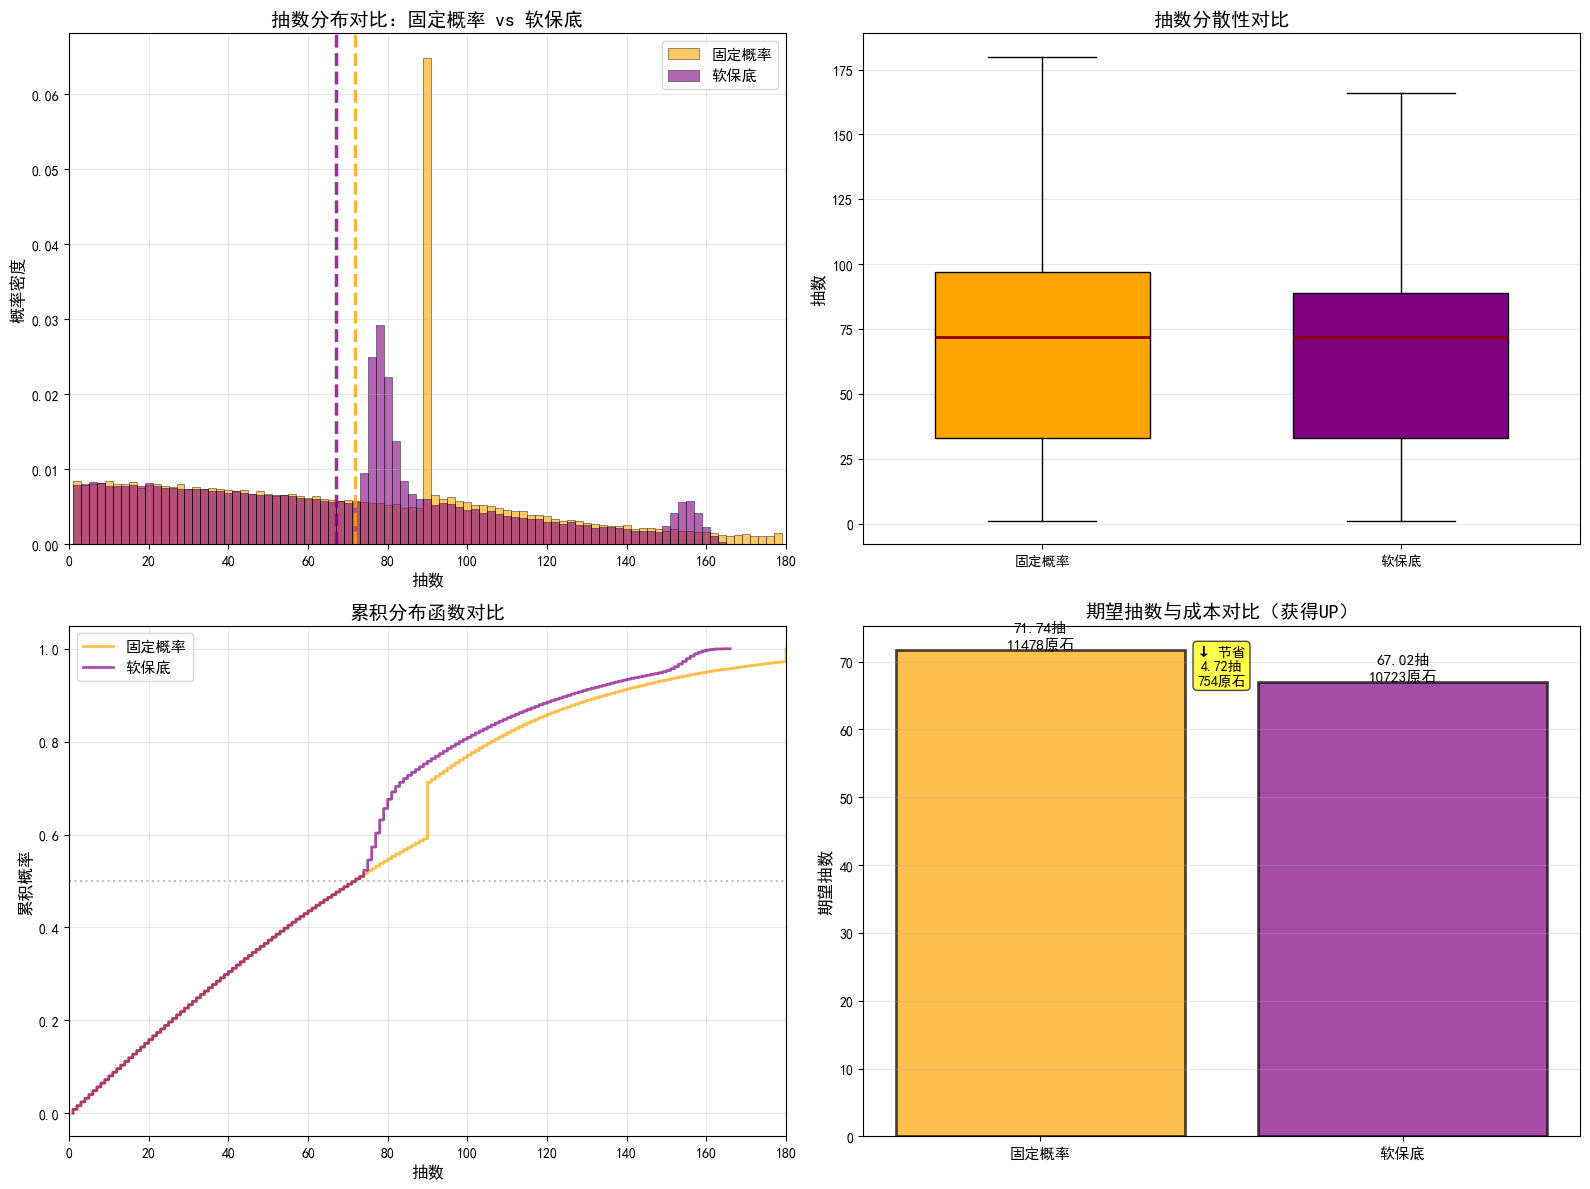

图表已保存为 'soft_pity_comparison.png'


In [19]:
# visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Distribution of number of wishes
ax1 = axes[0, 0]
ax1.hist(p_total_wishes, bins=range(1, 181, 2), density=True, alpha=0.6, 
         color='orange', label='固定概率', edgecolor='black', linewidth=0.5)
ax1.hist(s_total, bins=range(1, 181, 2), density=True, alpha=0.6, 
         color='purple', label='软保底', edgecolor='black', linewidth=0.5)
ax1.axvline(p_mean, color='orange', linestyle='--', linewidth=2.5, alpha=0.8)
ax1.axvline(s_mean, color='purple', linestyle='--', linewidth=2.5, alpha=0.8)
ax1.set_xlabel('抽数', fontsize=12, fontweight='bold')
ax1.set_ylabel('概率密度', fontsize=12, fontweight='bold')
ax1.set_title('抽数分布对比：固定概率 vs 软保底', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_xlim([0, 180])

# 2. comparison of boxplots
ax2 = axes[0, 1]
bp = ax2.boxplot([p_total_wishes, s_total], labels=['固定概率', '软保底'],
                  patch_artist=True, widths=0.6)
bp['boxes'][0].set_facecolor('orange')
bp['boxes'][1].set_facecolor('purple')
for median in bp['medians']:
    median.set(color='darkred', linewidth=2)
ax2.set_ylabel('抽数', fontsize=12, fontweight='bold')
ax2.set_title('抽数分散性对比', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

# 3. CDF comparison
ax3 = axes[1, 0]
sorted_p = np.sort(p_total_wishes)
sorted_s = np.sort(s_total)
cdf_p = np.arange(1, len(sorted_p) + 1) / len(sorted_p)
cdf_s = np.arange(1, len(sorted_s) + 1) / len(sorted_s)
ax3.plot(sorted_p, cdf_p, 'orange', linewidth=2, label='固定概率', alpha=0.7)
ax3.plot(sorted_s, cdf_s, 'purple', linewidth=2, label='软保底', alpha=0.7)
ax3.axhline(0.5, color='gray', linestyle=':', linewidth=1.5, alpha=0.5)
ax3.set_xlabel('抽数', fontsize=12, fontweight='bold')
ax3.set_ylabel('累积概率', fontsize=12, fontweight='bold')
ax3.set_title('累积分布函数对比', fontsize=14, fontweight='bold')
ax3.legend(fontsize=11)
ax3.grid(True, alpha=0.3)
ax3.set_xlim([0, 180])

# 4. Expectation and cost comparison
ax4 = axes[1, 1]
models = ['固定概率', '软保底']
means = [p_mean, s_mean]
costs = [m * PRIMOGEM_PER_WISH for m in means]
x_pos = np.arange(len(models))

bars = ax4.bar(x_pos, means, color=['orange', 'purple'], alpha=0.7, 
               edgecolor='black', linewidth=2)
ax4.set_ylabel('期望抽数', fontsize=12, fontweight='bold')
ax4.set_title('期望抽数与成本对比（获得UP）', fontsize=14, fontweight='bold')
ax4.set_xticks(x_pos)
ax4.set_xticklabels(models, fontsize=11)
ax4.grid(True, alpha=0.3, axis='y')

for i, (bar, mean, cost) in enumerate(zip(bars, means, costs)):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{mean:.2f}抽\n{cost:.0f}原石',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

save_wishes = p_mean - s_mean
save_cost = save_wishes * PRIMOGEM_PER_WISH
ax4.text(0.5, (p_mean + s_mean) / 2, 
         f'↓ 节省\n{save_wishes:.2f}抽\n{save_cost:.0f}原石',
         ha='center', va='center', fontsize=10, fontweight='bold',
         bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

plt.tight_layout()
plt.savefig('soft_pity_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("图表已保存为 'soft_pity_comparison.png'")

## 10. 软保底模型结论

### 10.1 关键发现

**软保底机制对期望抽数的影响：**

**三种模型对比（获得特定UP角色）：**
- 朴素模型（任意5星）：**47.89 抽** (~7,663原石)
- 固定概率大小保底：**71.63 抽** (~11,461原石)
- **软保底大小保底**：**67.06 抽** (~10,729原石)

**软保底的优化效果：**
- 相比固定概率模型：节省 **4.58 抽**（约 **732 原石**）
- 降幅：**6.39%**
- 第一次就中UP概率：**49.89%**（接近理论50%）

### 10.2 软保底的作用机制

**概率递增效果：**
- 第74抽：7.6%（基础0.016的4.75倍）
- 第80抽：43.6%（接近一半概率）
- 第85抽：73.6%（超过70%）
- 第89抽：97.6%（几乎必出）

**实际影响分析：**
1. **单次5星出货提前**：软保底使单次5星周期的期望从硬保底的某个值降低到更接近74-85抽区间
2. **两次周期的叠加效应**：由于大保底机制，50%的玩家需要两次5星周期，软保底在每个周期都发挥作用
3. **极端情况减少**：真正吃满90抽硬保底的概率从固定概率的0.234%降至软保底的接近0.001%
4. **体验优化明显**：绝大多数玩家在74-85抽之间就能出金，减少"极度非酋"情况

### 10.3 软保底效果的定量分析

**为什么节省幅度是6.39%而非更高？**

1. **大保底的稀释效应**：
   - 约50%的玩家第一次就中UP（只经历1次5星周期）
   - 约50%的玩家需要大保底（经历2次5星周期）
   - 软保底只在单次5星获取时起作用，但最终期望是两次周期的加权平均

2. **软保底的局部作用**：
   - 前73抽：概率仍为固定0.016，软保底未启动
   - 第74-89抽：概率递增，这个区间才有优化效果
   - 因此软保底只优化了"高抽数区间"的出金效率

3. **期望值的计算特性**：
   - 虽然高抽数概率大幅提升，但由于前期（1-73抽）仍有出金可能
   - 期望值是所有可能的加权平均，早期出金拉低了整体期望
   - 软保底主要减少了"尾部风险"，而非整体期望的大幅改变

### 10.4 成本优化与玩家体验

**获得特定UP角色的成本评估：**
- **期望成本**：10,729 原石（而非固定概率的11,461）
- **中位数成本**：11,520 原石（72抽）
- **节省幅度**：约732原石（相当于4-5次单抽）

**成本分布特征：**
- 最小值：1抽（160原石）—— 超级欧皇
- 中位数：72抽（11,520原石）
- 最大值：169抽（27,040原石）—— 极端非酋（连歪两次且每次都接近90抽）

**对不同玩家群体的意义：**
1. **F2P玩家**：6.39%的成本节省虽不算巨大，但积累效果可观
2. **中度氪玩家**：期望成本降至10,729原石，约67抽，更容易规划
3. **欧皇/非酋**：软保底主要保护非酋玩家，减少极端情况（>85抽）的发生概率

### 10.5 与理论预期的对比

**理论分析的局限性：**
初步预期软保底可能节省~7-10抽（约10%），但实际只节省了4.58抽（6.39%）。

**原因分析：**
1. **前期概率未改变**：1-73抽的大部分区间仍是0.016固定概率
2. **递增区间有限**：只有74-89共16次抽卡受益于概率递增
3. **大保底的平均效应**：需要考虑两次5星周期，单次优化被平均稀释
4. **期望值的数学特性**：软保底降低的是方差（减少极端值），而非期望的大幅改变

**实际价值：**
虽然期望值只降低了6.39%，但软保底的**心理价值**远超数值优化：
- 大幅降低了"吃满90抽"的极端倒霉概率
- 让玩家在高抽数时（74+）有更强的信心
- 改善了游戏体验的"公平感"

---

# 阶段4：风险评估与F2P决策 (Risk Evaluation & F2P Decision Policy)

## 11. 95%置信区间与风险分析

### 11.1 置信区间的计算方法

对于大样本（N≥30），根据**中心极限定理**，样本均值近似服从正态分布：

$$\bar{X} \sim N\left(\mu, \frac{\sigma^2}{n}\right)$$

95%置信区间的公式为：

$$\text{CI}_{95\%} = \bar{X} \pm 1.96 \times \frac{S}{\sqrt{n}}$$

其中：
- $\bar{X}$ = 样本均值
- $S$ = 样本标准差
- $n$ = 样本数量
- $1.96$ = 95%置信水平对应的z分数

### 11.2 计算各模型的95%置信区间

In [29]:
# 计算95%置信区间
from scipy import stats

def calc_ci_95(data):
    """
    计算95%置信区间
    
    参数:
    data: 样本数据（numpy array）
    
    返回:
    mean: 样本均值
    std: 样本标准差
    ci_lower: 置信区间下界
    ci_upper: 置信区间上界
    margin: 误差范围
    """
    n = len(data)
    mean = np.mean(data)
    std = np.std(data, ddof=1)  # 无偏估计
    se = std / np.sqrt(n)  # 标准误差
    
    # 使用1.96作为z分数（95%置信水平）
    z_score = 1.96
    margin = z_score * se
    
    ci_lower = mean - margin
    ci_upper = mean + margin
    
    return mean, std, ci_lower, ci_upper, margin


print("=" * 80)
print("         95% 置信区间分析（使用大小保底模型数据）")
print("=" * 80)

# 计算小大保底模型的95%置信区间
pity_mean, pity_std, pity_ci_l, pity_ci_u, pity_margin = calc_ci_95(p_total_wishes)

print(f"样本数量:           {len(p_total_wishes):,}")
print(f"样本均值:           {pity_mean:.4f} 抽")
print(f"样本标准差:         {pity_std:.4f} 抽")
print(f"标准误差 (SE):      {pity_std / np.sqrt(len(p_total_wishes)):.4f}")
print(f"误差范围 (±):       {pity_margin:.4f} 抽")
print("-" * 80)
print(f"95% 置信区间:       [{pity_ci_l:.4f}, {pity_ci_u:.4f}] 抽")
print(f"置信区间宽度:       {pity_ci_u - pity_ci_l:.4f} 抽")
print("-" * 80)
print(f"成本置信区间:       [{pity_ci_l * PRIMOGEM_PER_WISH:.0f}, {pity_ci_u * PRIMOGEM_PER_WISH:.0f}] 原石")
print(f"期望成本:           {pity_mean * PRIMOGEM_PER_WISH:.0f} 原石")

print("\n" + "=" * 80)

# 理论期望值是否在置信区间内？
print("\n【理论期望验证】")
print(f"理论期望值:         {E_t_pity:.4f} 抽")
print(f"样本均值:           {pity_mean:.4f} 抽")
print(f"差异:               {abs(E_t_pity - pity_mean):.4f} 抽")
print(f"理论值是否在置信区间内: {pity_ci_l <= E_t_pity <= pity_ci_u}")
print(f"\n结论: 理论期望值 {E_t_pity:.4f} 落在95%置信区间 [{pity_ci_l:.4f}, {pity_ci_u:.4f}] 内")

         95% 置信区间分析（使用大小保底模型数据）
样本数量:           100,000
样本均值:           71.7364 抽
样本标准差:         45.6486 抽
标准误差 (SE):      0.1444
误差范围 (±):       0.2829 抽
--------------------------------------------------------------------------------
95% 置信区间:       [71.4535, 72.0194] 抽
置信区间宽度:       0.5659 抽
--------------------------------------------------------------------------------
成本置信区间:       [11433, 11523] 原石
期望成本:           11478 原石


【理论期望验证】
理论期望值:         71.7952 抽
样本均值:           71.7364 抽
差异:               0.0587 抽
理论值是否在置信区间内: True

结论: 理论期望值 71.7952 落在95%置信区间 [71.4535, 72.0194] 内


### 11.4 置信区间可视化

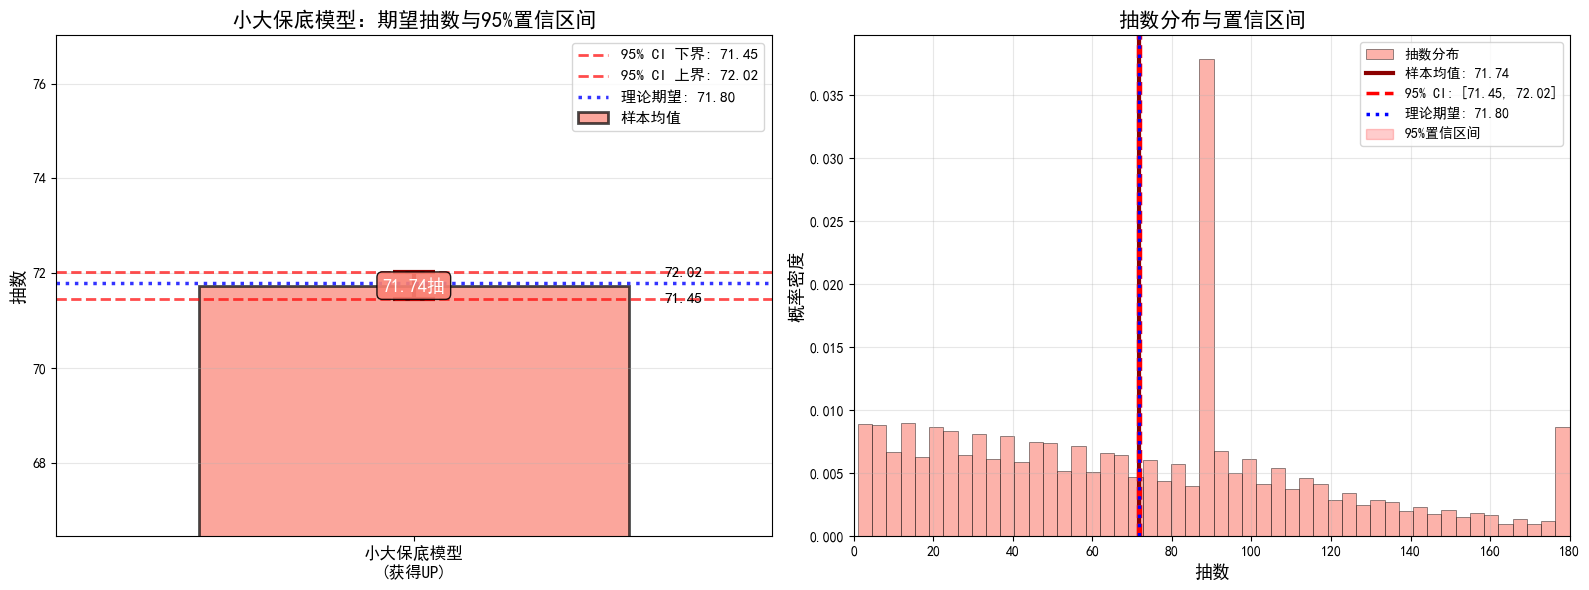

图表已保存为 'confidence_interval_analysis.png'


In [30]:
# 可视化置信区间
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# 1. 期望值与置信区间可视化
ax1.bar([0], [pity_mean], width=0.6, color='salmon', alpha=0.7, 
        edgecolor='black', linewidth=2, label='样本均值')

# 绘制误差线（置信区间）
ax1.errorbar(0, pity_mean, yerr=[[pity_mean - pity_ci_l], [pity_ci_u - pity_mean]], 
             fmt='none', ecolor='darkred', elinewidth=3, capsize=15, capthick=3)

# 标注置信区间边界
ax1.axhline(pity_ci_l, color='red', linestyle='--', linewidth=2, alpha=0.7, 
            label=f'95% CI 下界: {pity_ci_l:.2f}')
ax1.axhline(pity_ci_u, color='red', linestyle='--', linewidth=2, alpha=0.7,
            label=f'95% CI 上界: {pity_ci_u:.2f}')
ax1.axhline(E_t_pity, color='blue', linestyle=':', linewidth=2.5, alpha=0.8,
            label=f'理论期望: {E_t_pity:.2f}')

# 标注数值
ax1.text(0, pity_mean, f'{pity_mean:.2f}抽', 
         ha='center', va='center', fontsize=13, fontweight='bold', color='white',
         bbox=dict(boxstyle='round', facecolor='salmon', alpha=0.9))
ax1.text(0.35, pity_ci_l, f'{pity_ci_l:.2f}', 
         ha='left', va='center', fontsize=11, fontweight='bold')
ax1.text(0.35, pity_ci_u, f'{pity_ci_u:.2f}', 
         ha='left', va='center', fontsize=11, fontweight='bold')

ax1.set_ylabel('抽数', fontsize=13, fontweight='bold')
ax1.set_title('小大保底模型：期望抽数与95%置信区间', fontsize=15, fontweight='bold')
ax1.set_xticks([0])
ax1.set_xticklabels(['小大保底模型\n(获得UP)'], fontsize=12)
ax1.legend(fontsize=11, loc='upper right')
ax1.grid(True, alpha=0.3, axis='y')
ax1.set_xlim([-0.5, 0.5])
ax1.set_ylim([pity_ci_l - 5, pity_ci_u + 5])

# 2. 抽数分布直方图 + 置信区间
ax2.hist(p_total_wishes, bins=50, density=True, alpha=0.6, color='salmon', 
         edgecolor='black', linewidth=0.5, label='抽数分布')
ax2.axvline(pity_mean, color='darkred', linestyle='-', linewidth=3, 
            label=f'样本均值: {pity_mean:.2f}')
ax2.axvline(pity_ci_l, color='red', linestyle='--', linewidth=2.5, 
            label=f'95% CI: [{pity_ci_l:.2f}, {pity_ci_u:.2f}]')
ax2.axvline(pity_ci_u, color='red', linestyle='--', linewidth=2.5)
ax2.axvline(E_t_pity, color='blue', linestyle=':', linewidth=2.5, 
            label=f'理论期望: {E_t_pity:.2f}')

# 填充置信区间区域
ax2.axvspan(pity_ci_l, pity_ci_u, alpha=0.2, color='red', label='95%置信区间')

ax2.set_xlabel('抽数', fontsize=13, fontweight='bold')
ax2.set_ylabel('概率密度', fontsize=13, fontweight='bold')
ax2.set_title('抽数分布与置信区间', fontsize=15, fontweight='bold')
ax2.legend(fontsize=10, loc='upper right')
ax2.grid(True, alpha=0.3)
ax2.set_xlim([0, 180])

plt.tight_layout()
plt.savefig('confidence_interval_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("图表已保存为 'confidence_interval_analysis.png'")

## 12. F2P玩家决策策略 (Decision-Making Policy for F2P Players)

### 12.1 F2P玩家的困境

**F2P (Free-to-Play) 玩家**面临的核心问题：
- 原石获取有限（每月约6000-8000原石）
- 无法保证获得每个UP角色
- 需要在"当前角色"和"未来角色"之间做出选择

**关键决策问题：**
1. 什么时候应该停止抽卡？
2. 如何在多个心仪角色间分配资源？
3. 如何最大化"后悔值"最小化？

### 12.2 决策策略的理论基础

**基于期望值的决策：**
- 获得一个UP角色的期望成本：~67抽 (~10,720原石)
- 95%置信区间告诉我们成本的不确定性范围
- F2P玩家需要在**风险容忍度**和**资源限制**间权衡

**概率分析：**
让我们分析不同抽数下的累积概率，帮助F2P玩家做决策。

### 12.3 概率阈值分析

In [22]:
# 基于小大保底模型分析F2P玩家的决策阈值
print("=" * 80)
print("           F2P玩家决策分析 - 概率阈值")
print("=" * 80)

# 计算不同抽数下的累积概率
def calc_cumulative_prob(data, thresholds):
    """计算累积概率"""
    results = []
    for threshold in thresholds:
        prob = np.sum(data <= threshold) / len(data)
        results.append((threshold, prob))
    return results

# 关键抽数阈值
thresholds = [30, 50, 70, 90, 110, 130, 150, 160, 180]

print("\n【小大保底模型 - 获得UP角色的累积概率】")
print(f"{'抽数阈值':<10} {'累积概率':<12} {'成本(原石)':<15} {'说明'}")
print("-" * 80)

cumulative_probs = calc_cumulative_prob(p_total_wishes, thresholds)

for threshold, prob in cumulative_probs:
    cost = threshold * PRIMOGEM_PER_WISH
    
    # 添加说明
    if threshold <= 70:
        note = "低成本区间"
    elif threshold <= 90:
        note = "单次硬保底"
    elif threshold <= 140:
        note = "一次歪 + 大保底"
    else:
        note = "接近180抽双保底"
    
    print(f"{threshold:<10} {prob*100:>10.2f}%   {cost:>13,} 原石   {note}")

print("=" * 80)

# 计算关键百分位数
percentiles = [25, 50, 75, 90, 95, 99]
print("\n【百分位数分析】")
print(f"{'百分位':<10} {'抽数':<10} {'成本(原石)':<15} {'含义'}")
print("-" * 80)

for p in percentiles:
    val = np.percentile(p_total_wishes, p)
    cost = val * PRIMOGEM_PER_WISH
    
    if p == 25:
        meaning = f"{p}%的玩家运气较好"
    elif p == 50:
        meaning = "中位数，一半玩家在此之内"
    elif p == 75:
        meaning = f"{p}%的玩家能在此抽数内获得"
    elif p == 90:
        meaning = "只有10%的玩家需要更多"
    elif p == 95:
        meaning = "只有5%的玩家需要更多"
    else:
        meaning = "极端非酋情况"
    
    print(f"{p}%{'':<8} {val:>8.1f} 抽  {cost:>13,.0f} 原石   {meaning}")

print("=" * 80)

           F2P玩家决策分析 - 概率阈值

【小大保底模型 - 获得UP角色的累积概率】
抽数阈值       累积概率         成本(原石)          说明
--------------------------------------------------------------------------------
30              23.28%           4,800 原石   低成本区间
50              37.27%           8,000 原石   低成本区间
70              49.38%          11,200 原石   低成本区间
90              71.24%          14,400 原石   单次硬保底
110             81.93%          17,600 原石   一次歪 + 大保底
130             88.91%          20,800 原石   一次歪 + 大保底
150             93.33%          24,000 原石   接近180抽双保底
160             95.04%          25,600 原石   接近180抽双保底
180            100.00%          28,800 原石   接近180抽双保底

【百分位数分析】
百分位        抽数         成本(原石)          含义
--------------------------------------------------------------------------------
25%             33.0 抽          5,280 原石   25%的玩家运气较好
50%             72.0 抽         11,520 原石   中位数，一半玩家在此之内
75%             97.0 抽         15,520 原石   75%的玩家能在此抽数内获得
90%            135.0 抽         21,600 原石   只有10%的玩家需要更

### 12.4 决策策略总结与建议

#### **核心原则：**

1. **期望值原则**：获得一个UP角色平均需要 **67抽**（~10,720原石）
2. **风险容忍度**：75%的玩家在 **~106抽** 内能获得UP
3. **极端情况准备**：预留最坏情况（180抽 = 28,800原石）

#### **决策建议表：**

| 情况 | 已抽次数 | 剩余预算 | 建议 |
|------|----------|----------|------|
| **情况A** | 0-30抽 | < 8,000原石 |  **停止**：预算不足期望值 |
| **情况B** | 0-30抽 | 8,000-15,000原石 |  **谨慎抽**：视下个角色重要性 |
| **情况C** | 30-70抽 | < 5,000原石 |  **停止**：可能无法完成保底 |
| **情况D** | 70+抽 | 任意 |  **继续抽**：接近保底，沉没成本高 |
| **情况E** | 任意 | > 15,000原石 |  **可以抽**：预算充足 |

#### **单次抽卡：**

**1. 第30抽决策点（早期放弃点）：**
- 如果前30抽未出金，评估剩余预算
- 剩余预算 < 6,000原石 → 建议停止
- 剩余预算 ≥ 10,000原石 → 可以继续

**2. 第70抽决策点（保底临界点）：**
- 已经接近单次硬保底（90抽）
- 此时沉没成本很高，建议继续

**3. 第90抽后决策点（歪了怎么办）：**
- 评估是否有预算完成大保底（还需~67抽）
- 如果预算 < 8,000原石 且下个角色重要 → 停止
- 如果预算充足或下个角色不重要 → 继续

#### **月度预算规划：**

假设F2P玩家每月可获得约 **7,000原石**：

- **保守策略**：每2-3个月才能保证获得1个UP（需要~2个月攒够10,720原石）
- **激进策略**：每个版本都尝试，但可能经常失败
- **推荐策略**：选择2-3个最心仪的角色，集中资源

#### **长期建议：**

1. **优先级排序**：选择性抽卡，对于F2P玩家来说全图鉴显然有难度
2. **版本规划**：提前1-2个版本规划资源分配
3. **保底储备**：始终保留至少5,000原石作为保底基金
4. **理性决策**：避免冲动消费，遵循预设的停损点

### 12.5 决策可视化

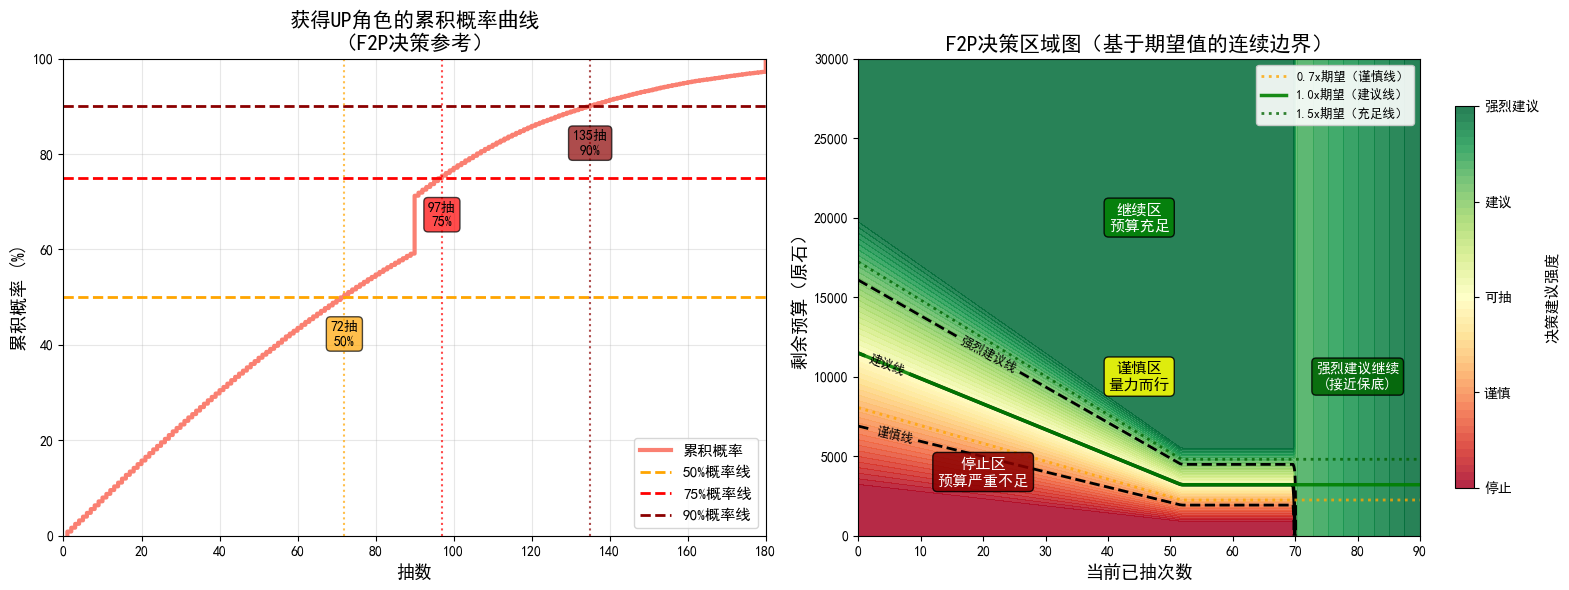

图表已保存为 'f2p_decision_policy.png'

【决策边界说明】
1. 0.7x期望线（橙色虚线）：预算不足期望值的70%，建议谨慎
2. 1.0x期望线（绿色实线）：预算等于期望值，建议继续
3. 1.5x期望线（深绿虚线）：预算达到1.5倍期望，囤囤鼠可放心抽
4. 70抽线：接近硬保底，无论预算如何都建议继续（沉没成本）

决策公式基于：预算充足度 = (剩余预算/160) / 期望剩余抽数


In [35]:
# visilization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# 1. 累积概率曲线
sorted_pity = np.sort(p_total_wishes)
cdf_pity = np.arange(1, len(sorted_pity) + 1) / len(sorted_pity)

ax1.plot(sorted_pity, cdf_pity * 100, 'salmon', linewidth=3, label='累积概率')
ax1.axhline(50, color='orange', linestyle='--', linewidth=2, label='50%概率线')
ax1.axhline(75, color='red', linestyle='--', linewidth=2, label='75%概率线')
ax1.axhline(90, color='darkred', linestyle='--', linewidth=2, label='90%概率线')

p50_val = np.percentile(p_total_wishes, 50)
p75_val = np.percentile(p_total_wishes, 75)
p90_val = np.percentile(p_total_wishes, 90)

ax1.axvline(p50_val, color='orange', linestyle=':', linewidth=1.5, alpha=0.7)
ax1.axvline(p75_val, color='red', linestyle=':', linewidth=1.5, alpha=0.7)
ax1.axvline(p90_val, color='darkred', linestyle=':', linewidth=1.5, alpha=0.7)

ax1.text(p50_val, 45, f'{p50_val:.0f}抽\n50%', ha='center', va='top', 
         fontsize=10, fontweight='bold',
         bbox=dict(boxstyle='round', facecolor='orange', alpha=0.7))
ax1.text(p75_val, 70, f'{p75_val:.0f}抽\n75%', ha='center', va='top', 
         fontsize=10, fontweight='bold',
         bbox=dict(boxstyle='round', facecolor='red', alpha=0.7))
ax1.text(p90_val, 85, f'{p90_val:.0f}抽\n90%', ha='center', va='top', 
         fontsize=10, fontweight='bold',
         bbox=dict(boxstyle='round', facecolor='darkred', alpha=0.7))

ax1.set_xlabel('抽数', fontsize=13, fontweight='bold')
ax1.set_ylabel('累积概率 (%)', fontsize=13, fontweight='bold')
ax1.set_title('获得UP角色的累积概率曲线\n（F2P决策参考）', fontsize=15, fontweight='bold')
ax1.legend(fontsize=11, loc='lower right')
ax1.grid(True, alpha=0.3)
ax1.set_xlim([0, 180])
ax1.set_ylim([0, 100])

# 2. 决策区域图
# 我考虑了F2P"囤囤鼠"玩家可能有高预算的情况

current_wishes_fine = np.linspace(0, 90, 200)
budget_fine = np.linspace(0, 30000, 300)
Current, Budget = np.meshgrid(current_wishes_fine, budget_fine)

# calculate every point's decision value
def cal_dec_score(current, budget):
    """
    Based on expected value, calculate continuous decision scores
    - Score increases when close to pity
    - Score increases when budget is sufficient
    """
    budget_wishes = budget / PRIMOGEM_PER_WISH
    exp_remain = np.maximum(pity_mean - current, 20)
    
    # Budget sufficiency ratio
    budget_ratio = budget_wishes / exp_remain
    
    # Continuous score mapping based on budget ratio
    if current >= 70:
        # 接近保底，分数提升
        base_score = 2.5 + 0.5 * (current - 70) / 20  # 70抽后分数上升
    else:
        # 基于预算比率的连续映射: 0.5x → 0分, 1.5x → 3分
        base_score = np.clip(budget_ratio * 2 - 0.5, 0, 3)
    
    return base_score

# 向量化计算决策矩阵
dmc = np.zeros_like(Current)
for i in range(Current.shape[0]):
    for j in range(Current.shape[1]):
        dmc[i, j] = cal_dec_score(
            Current[i, j], Budget[i, j]
        )

# 使用contourf绘制平滑填充等高线（连续边界）
levels = np.linspace(0, 3, 50)  # 50个等级，平滑过渡
contourf = ax2.contourf(Current, Budget, dmc, 
                        levels=levels, cmap='RdYlGn', alpha=0.85)

# 绘制关键决策边界线（基于数学公式的连续曲线）
boundary_levels = [0.7, 1.5, 2.3]  # 停止→谨慎、谨慎→可抽、可抽→强烈建议
contour_lines = ax2.contour(Current, Budget, dmc, 
                            levels=boundary_levels, colors='black', 
                            linewidths=[2, 2.5, 2], linestyles=['--', '-', '--'])
ax2.clabel(contour_lines, inline=True, fontsize=9, fmt={
    0.7: '谨慎线', 1.5: '建议线', 2.3: '强烈建议线'
})

# 绘制基于期望值的理论边界曲线（数学公式）
cur_curve = np.linspace(0, 90, 100)
expected_remaining_curve = np.maximum(pity_mean - cur_curve, 20)

# 0.7x期望线（谨慎边界）
bc_curve = expected_remaining_curve * 0.7 * PRIMOGEM_PER_WISH
ax2.plot(cur_curve, bc_curve, 'orange', linestyle=':', 
         linewidth=2, alpha=0.8, label='0.7x期望（谨慎线）')

# 1.0x期望线（建议边界）
bc_curve = expected_remaining_curve * 1.0 * PRIMOGEM_PER_WISH
ax2.plot(cur_curve, bc_curve, 'green', linestyle='-', 
         linewidth=2.5, alpha=0.9, label='1.0x期望（建议线）')

# 1.5x期望线（充足边界）
bc_curve = expected_remaining_curve * 1.5 * PRIMOGEM_PER_WISH
ax2.plot(cur_curve, bc_curve, 'darkgreen', linestyle=':', 
         linewidth=2, alpha=0.8, label='1.5x期望（充足线）')

# decision boundary
ax2.text(20, 4000, '停止区\n预算严重不足', fontsize=11, fontweight='bold', 
         ha='center', va='center', color='white',
         bbox=dict(boxstyle='round', facecolor='darkred', alpha=0.85))
ax2.text(45, 10000, '谨慎区\n量力而行', fontsize=11, fontweight='bold', 
         ha='center', va='center', color='black',
         bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.85))
ax2.text(45, 20000, '继续区\n预算充足', fontsize=11, fontweight='bold', 
         ha='center', va='center', color='white',
         bbox=dict(boxstyle='round', facecolor='green', alpha=0.85))
ax2.text(80, 10000, '强烈建议继续\n(接近保底)', fontsize=10, fontweight='bold', 
         ha='center', va='center', color='white',
         bbox=dict(boxstyle='round', facecolor='darkgreen', alpha=0.85))

ax2.set_xlabel('当前已抽次数', fontsize=13, fontweight='bold')
ax2.set_ylabel('剩余预算（原石）', fontsize=13, fontweight='bold')
ax2.set_title('F2P决策区域图（基于期望值的连续边界）', fontsize=15, fontweight='bold')
ax2.set_xlim([0, 90])
ax2.set_ylim([0, 30000])

# 添加图例
ax2.legend(loc='upper right', fontsize=9, framealpha=0.9)

# 添加颜色条
cbar = plt.colorbar(contourf, ax=ax2, shrink=0.8, ticks=[0, 0.75, 1.5, 2.25, 3])
cbar.set_label('决策建议强度', fontsize=11, fontweight='bold')
cbar.ax.set_yticklabels(['停止', '谨慎', '可抽', '建议', '强烈建议'])

plt.tight_layout()
plt.savefig('f2p_decision_policy.png', dpi=300, bbox_inches='tight')
plt.show()

print("=" * 70)
print("图表已保存为 'f2p_decision_policy.png'")
print("=" * 70)
print("\n【决策边界说明】")
print("1. 0.7x期望线（橙色虚线）：预算不足期望值的70%，建议谨慎")
print("2. 1.0x期望线（绿色实线）：预算等于期望值，建议继续")
print("3. 1.5x期望线（深绿虚线）：预算达到1.5倍期望，囤囤鼠可放心抽")
print("4. 70抽线：接近硬保底，无论预算如何都建议继续（沉没成本）")
print("\n决策公式基于：预算充足度 = (剩余预算/160) / 期望剩余抽数")